<h1>Предсказание рисков сердечного приступа</h1>
Допустим, компания по исследованию серднечно-сосудистых заболеваний заказала исследование вероятности рисков сердечного приступа.<br/>
<b>Задачи проекта:</b><br>
1) Исследование датасета (предполагается поиск дополнительной информации для лучшего понимания природы данных)<br>
2) Предобработка данных.(в данных могут быть бесполезные признаки, сильно скорелированные признаки а также косвенные утечки целевого признака. Некоторые колонки потребуется преобразовать к нужному типу данных)<br>
3) Обучение модели<br>
4) Подготовка предсказания на тестовой выборке. (Файл предсказаний должен быть в csv формате и содержать 2 столбца: “id” и “prediction”)<br>
5) Подготовка скриптов и библиотеки для обработки данных и предсказания на тестовой выборке<br>
6) Написание инструмента для тестирования<br>
7) Оформление документации<br>

Для анализа предоставленны следующие данные:<br/>
heart_test.csv - тестовая выборка (без целевого признака)<br/>
heart_train.csv  — обучающая выборка<br/>
id  - id<br/>
Антропометрические параметры (вес, возраст, рост)<br/>
Привычки (курение, качество сна и т.д)<br/>
Давление<br/>
Наличие хронических заболеваний<br/>
Биохимия крови<br/>
Таргет - высокий или низкий риск поражения сердца<br/>

<b>План работ</b><br>

1. Загрузка и подготовка данных (парсинг, нейминг столбцов, явные и неявные дубликаты, пропуски)<br>
2. Исследовательский анализ данных (описание данных, статистических анализ всех признаков с гистограммами для количественных и столбчатами/круговыми диаграммами для качественных признаков, выбросы, рекомендации по улучшению данных, их применение)
3. Корреляционный анализ признаков в датасете (диаграмма рассеяния, матрица корреляции)
4. Обучение и проверка модели c использованием pipeline (LogisticRegression, CatBoost), выбор метрики (ROC-AUC или F1-score)<br>
5. Подготовка предсказания на тестовой выборке<br>
6. Написание инструмента для тестирования<br>
7. Оформление документации<br>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.5 MB/s eta 0:00:00


In [ ]:
import os
import shap
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix
from sklearn.dummy import DummyClassifier

<h2>1. Загрузка и подготовка данных</h2>

Установим константы

In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

Для удобства загрузки воспользуемся кастомной функцией

In [ ]:
def load_dataset(filepath, sep=';'):
    """
    Загружает CSV-файл и возвращает DataFrame.
    Обрабатывает ошибки FileNotFound и другие исключения.

    Параметры:
    - filepath (str): путь к файлу
    - sep (str): разделитель в CSV (по умолчанию ';')

    Возвращает:
    - DataFrame при успешной загрузке, иначе None
    """
    if os.path.exists(filepath):
        pd.set_option('display.max_columns', None)
        pd.set_option('display.expand_frame_repr', False)
        df = pd.read_csv(filepath)
        pd.read_csv(filepath, sep=sep)
        display(df.head(10))
        return df
    else:
        print('Файл не найден: {filepath}')

In [ ]:
train_data = load_dataset('/content/drive/MyDrive/Colab Notebooks/ya/heart_train.csv', ',')

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,1.0,0.0,8.0,0.225704,0.105948,0.459176,0.979221,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,1.0,0.0,9.0,0.289923,0.164217,0.117053,0.515584,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,1.0,1.0,6.0,0.550133,0.598745,0.373574,0.012987,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,0.0,1.0,3.0,0.330962,0.077605,0.049735,0.131169,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,0.0,0.0,8.0,0.524600,0.341960,0.830405,0.070130,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047
5,5,0.168539,0.764286,0.057745,0.0,1.0,1.0,1.0,1.0,0.082682,1,1.0,0.0,7.0,0.558262,0.640836,0.110571,0.238961,6.0,0.833333,0.0,0.227018,0.048229,0.036512,Male,0.464516,0.418605,5817
6,6,0.483146,0.021429,0.036664,1.0,0.0,1.0,0.0,1.0,0.540206,2,0.0,1.0,9.0,0.827611,0.774609,0.073718,0.072727,5.0,0.000000,1.0,0.231225,0.008940,0.000291,Male,0.361290,0.569767,5580
7,7,0.235955,0.939286,0.081577,1.0,0.0,1.0,0.0,1.0,0.290837,2,0.0,1.0,7.0,0.225275,0.999364,0.001534,0.180519,4.0,0.000000,0.0,0.227018,0.048229,0.036512,Male,0.690323,0.639535,4963
8,8,0.685393,0.317857,0.039413,0.0,0.0,1.0,0.0,0.0,0.803160,0,1.0,1.0,3.0,0.828176,0.142208,0.093073,0.990909,6.0,0.166667,1.0,0.126482,0.002332,0.007185,Male,0.664516,0.616279,4521
9,9,0.213483,0.796429,0.076994,1.0,1.0,1.0,1.0,0.0,0.506971,1,0.0,0.0,7.0,0.692973,0.820952,0.145447,0.171429,3.0,1.000000,0.0,0.227018,0.048229,0.036512,Male,0.651613,0.720930,2455


In [ ]:
test_data = load_dataset('/content/drive/MyDrive/Colab Notebooks/ya/heart_test.csv', ',')

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,2,0.0,0.0,8.0,0.194370,0.587759,0.283490,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,2,1.0,1.0,5.0,0.329888,0.602883,0.467036,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,0,0.0,0.0,10.0,0.780075,0.370436,0.409366,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,0,0.0,0.0,10.0,0.785071,0.368242,0.910261,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,0,0.0,0.0,7.0,0.070919,0.729578,0.758924,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825
5,5,0.561798,0.792857,0.026581,1.0,1.0,1.0,1.0,0.0,0.774470,2,0.0,1.0,8.0,0.044114,0.813517,0.723416,0.362338,1.0,0.666667,0.227018,0.048229,0.036512,Male,0.161290,0.593023,1076
6,6,0.674157,0.853571,0.019248,1.0,1.0,1.0,0.0,1.0,0.149123,1,0.0,0.0,8.0,0.305998,0.562542,0.696128,0.211688,3.0,0.000000,0.227018,0.048229,0.036512,Male,0.535484,0.546512,5020
7,7,0.539326,0.335714,0.036664,1.0,1.0,1.0,0.0,1.0,0.329720,1,1.0,0.0,1.0,0.377016,0.235091,0.484368,0.835065,7.0,0.666667,0.695652,0.002466,0.000874,Male,0.496774,0.662791,4267
8,8,0.449438,0.328571,0.075160,1.0,0.0,1.0,0.0,0.0,0.487405,2,1.0,0.0,10.0,0.089371,0.486634,0.409407,0.819481,2.0,0.166667,0.227018,0.048229,0.036512,Male,0.677419,0.430233,4003
9,9,0.617978,0.728571,0.032081,0.0,1.0,1.0,0.0,0.0,0.211485,2,1.0,1.0,8.0,0.524318,0.083936,0.657387,0.196104,0.0,1.000000,0.227018,0.048229,0.036512,Male,0.722581,0.255814,2519


Приведём названия столбцов для каждого из датасетов к стандартному

In [ ]:
train_data.columns = train_data.columns.str.lower().str.replace(' ', '_').str.replace(':', '').str.replace('(', '').str.replace(')', '')
train_data.columns

Index(['unnamed_0', 'age', 'cholesterol', 'heart_rate', 'diabetes',
       'family_history', 'smoking', 'obesity', 'alcohol_consumption',
       'exercise_hours_per_week', 'diet', 'previous_heart_problems',
       'medication_use', 'stress_level', 'sedentary_hours_per_day', 'income',
       'bmi', 'triglycerides', 'physical_activity_days_per_week',
       'sleep_hours_per_day', 'heart_attack_risk_binary', 'blood_sugar',
       'ck-mb', 'troponin', 'gender', 'systolic_blood_pressure',
       'diastolic_blood_pressure', 'id'],
      dtype='object')

In [ ]:
test_data.columns = test_data.columns.str.lower().str.replace(' ', '_').str.replace(':', '')
test_data.columns

Index(['unnamed_0', 'age', 'cholesterol', 'heart_rate', 'diabetes',
       'family_history', 'smoking', 'obesity', 'alcohol_consumption',
       'exercise_hours_per_week', 'diet', 'previous_heart_problems',
       'medication_use', 'stress_level', 'sedentary_hours_per_day', 'income',
       'bmi', 'triglycerides', 'physical_activity_days_per_week',
       'sleep_hours_per_day', 'blood_sugar', 'ck-mb', 'troponin', 'gender',
       'systolic_blood_pressure', 'diastolic_blood_pressure', 'id'],
      dtype='object')

Посмотрим, данные какого типа представлены в каждом из датасетов

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   unnamed_0                        8685 non-null   int64  
 1   age                              8685 non-null   float64
 2   cholesterol                      8685 non-null   float64
 3   heart_rate                       8685 non-null   float64
 4   diabetes                         8442 non-null   float64
 5   family_history                   8442 non-null   float64
 6   smoking                          8442 non-null   float64
 7   obesity                          8442 non-null   float64
 8   alcohol_consumption              8442 non-null   float64
 9   exercise_hours_per_week          8685 non-null   float64
 10  diet                             8685 non-null   int64  
 11  previous_heart_problems          8442 non-null   float64
 12  medication_use      

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   unnamed_0                        966 non-null    int64  
 1   age                              966 non-null    float64
 2   cholesterol                      966 non-null    float64
 3   heart_rate                       966 non-null    float64
 4   diabetes                         935 non-null    float64
 5   family_history                   935 non-null    float64
 6   smoking                          935 non-null    float64
 7   obesity                          935 non-null    float64
 8   alcohol_consumption              935 non-null    float64
 9   exercise_hours_per_week          966 non-null    float64
 10  diet                             966 non-null    int64  
 11  previous_heart_problems          935 non-null    float64
 12  medication_use        

Типы данных выглядят корректными

Проверим данные на наличие пропусков

In [ ]:
train_missing = train_data.isnull().sum()
test_missing = test_data.isna().sum()
print('Количество пропусков в train_data: {:}, в test_data: {:}'.format(train_missing, test_missing))

Количество пропусков в train_data: unnamed_0                            0
age                                  0
cholesterol                          0
heart_rate                           0
diabetes                           243
family_history                     243
smoking                            243
obesity                            243
alcohol_consumption                243
exercise_hours_per_week              0
diet                                 0
previous_heart_problems            243
medication_use                     243
stress_level                       243
sedentary_hours_per_day              0
income                               0
bmi                                  0
triglycerides                        0
physical_activity_days_per_week    243
sleep_hours_per_day                  0
heart_attack_risk_binary             0
blood_sugar                          0
ck-mb                                0
troponin                             0
gender                       

В train и test пропущены одни и те же признаки (243 и 31 строк соответственно):

            Diabetes, Family History, Smoking, Obesity, Alcohol Consumption

            Previous Heart Problems, Medication Use, Stress Level

            Physical Activity Days Per Week — проведём анализ данных, чтобы решить, заполнить пропуски или удалить

Проверим данные на наличие явных дубликатов

In [ ]:
train_dupl = train_data.duplicated().sum()
test_dupl = test_data.duplicated().sum()
print('Количество пропусков в train_data: {:}, в test_data: {:}'.format(train_dupl, test_dupl))

Количество пропусков в train_data: 0, в test_data: 0


Явных дубликатов нет

Признак unnamed_0 выгглядит как номер строки по порядку, удалим его, как неинформативный, предварительно создав копии датасетов

In [ ]:
train_data_copy = train_data.copy()
test_data_copy = test_data.copy()

train_data_copy.drop(columns=['unnamed_0'], inplace=True, errors='ignore')
test_data_copy.drop(columns=['unnamed_0'], inplace=True, errors='ignore')

train_data_copy.head(5)

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_binary,blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,1.0,0.0,8.0,0.225704,0.105948,0.459176,0.979221,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,1.0,0.0,9.0,0.289923,0.164217,0.117053,0.515584,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,1.0,1.0,6.0,0.550133,0.598745,0.373574,0.012987,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,0.0,1.0,3.0,0.330962,0.077605,0.049735,0.131169,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,0.0,0.0,8.0,0.524600,0.341960,0.830405,0.070130,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047


In [ ]:
test_data_copy.head(5)

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,2,0.0,0.0,8.0,0.194370,0.587759,0.283490,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,2,1.0,1.0,5.0,0.329888,0.602883,0.467036,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,0,0.0,0.0,10.0,0.780075,0.370436,0.409366,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,0,0.0,0.0,10.0,0.785071,0.368242,0.910261,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,0,0.0,0.0,7.0,0.070919,0.729578,0.758924,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825


В результате предобработки данных названия столбцов были приведены к единому виду. Данные каждого из датасетов были проверены на наличие явных дубликатов, их обнаружено не было <br>
Целевой признак: Heart Attack Risk (Binary) — бинарный флаг (0/1), присутствует только в train.
Были обнаружены пропуски для одних и тех же признаков в тренировочной и тестовой выборках:
Diabetes, Family History, Smoking, Obesity, Alcohol Consumption
Previous Heart Problems, Medication Use, Stress Level
Physical Activity Days Per Week
после исследовательского анализа данных будет необходимо обработать эти пропуски (удалить или заполнить)
Был удалён признак unnamed_0 как неинформативный

<h2>2. Исследовательский анализ данных</h2>
В рамках исследовательского анализа данных проведём статистический анализ всех признаков и построим гафики для каждого признака, при этом будем учитывать
Для удобства разделим все признаки на качественные, количественные и дискретные

In [ ]:
# Группировка признаков

quantitative_features = [
    'age', 'cholesterol', 'heart_rate', 'exercise_hours_per_week',
    'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides',
    'sleep_hours_per_day', 'blood_sugar', 'ck-mb', 'troponin',
    'systolic_blood_pressure', 'diastolic_blood_pressure'
]

categorical_features = ['gender', 'diet']

discrete_binary_features = [
    'diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption',
    'previous_heart_problems', 'medication_use', 'stress_level',
    'physical_activity_days_per_week'
]

target = 'heart_attack_risk_binary'

In [ ]:
# Статистическое описание количественных признаков
train_data_copy[quantitative_features].describe()

,age,cholesterol,heart_rate,exercise_hours_per_week,sedentary_hours_per_day,income,bmi,triglycerides,sleep_hours_per_day,blood_sugar,ck-mb,troponin,systolic_blood_pressure,diastolic_blood_pressure
count,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000
mean,0.449958,0.501070,0.050658,0.503378,0.499164,0.496055,0.496774,0.505484,0.503737,0.227339,0.048159,0.036689,0.450295,0.497634
std,0.231174,0.284716,0.023453,0.284810,0.285340,0.284698,0.282561,0.286320,0.328061,0.076635,0.075531,0.060157,0.170184,0.171830
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.258427,0.267857,0.034830,0.263286,0.255875,0.251922,0.254190,0.263636,0.166667,0.227018,0.048229,0.036512,0.303226,0.348837
50%,0.460674,0.499780,0.050412,0.502110,0.499920,0.494889,0.494774,0.503603,0.500000,0.227018,0.048229,0.036512,0.445161,0.500000
75%,0.640449,0.746429,0.065995,0.748709,0.744623,0.741036,0.736974,0.750649,0.833333,0.227018,0.048229,0.036512,0.600000,0.651163
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Перейдём к построению графиков для количественных признаков. Для этого создадим функцию, которая построит гистограмму и ящик с усами


In [ ]:
def plot_quantitative_feature(df, feature):
    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(df[feature], bins=30, kde=True)
    plt.title(f'Гистограмма: {feature}')
    plt.xlabel(feature)

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[feature])
    plt.title(f'Ящик с усами: {feature}')
    plt.xlabel(feature)

    plt.tight_layout()
    plt.show()

Посторим диаграммы для каждого из признаков

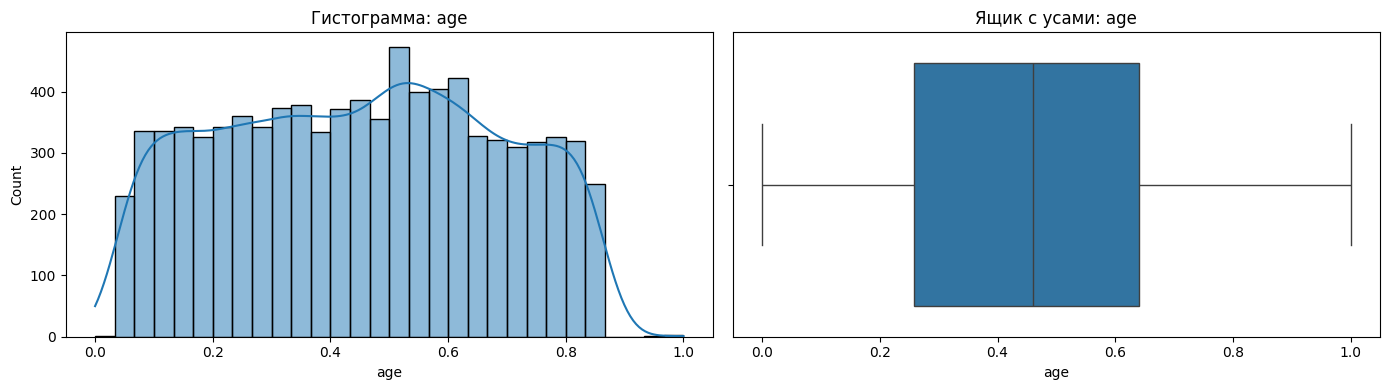

In [ ]:
plot_quantitative_feature(train_data_copy, 'age')

Признак age нормализован (масштабирован) от 0 до 1, распределение близко к равномерному
На boxplot выбросов практически нет — диапазон плотный и компактный

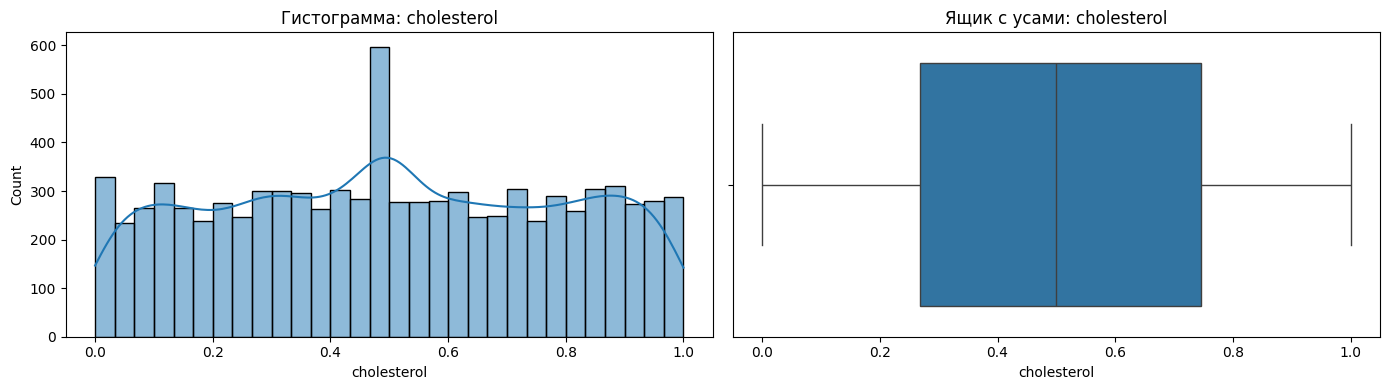

In [ ]:
plot_quantitative_feature(train_data_copy, 'cholesterol')

Признак cholesterol нормализован от 0 до 1, пик на 0.5
Выбросов нет

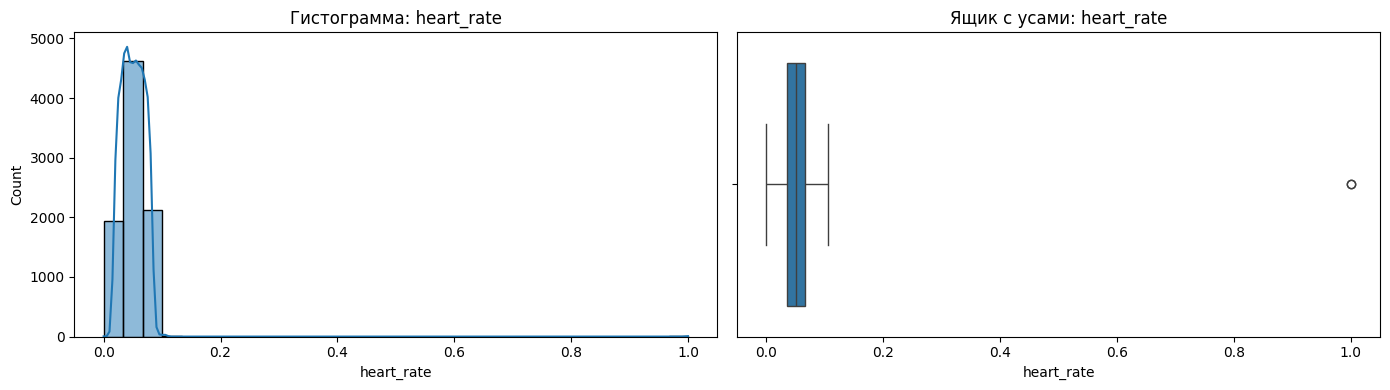

In [ ]:
plot_quantitative_feature(train_data_copy, 'heart_rate')

Признак heart_rate нормализован от 0 до 1, большинство значений сконцентрированы в интервале 0.02 – 0.08
Есть выброс в районе 1, рассмотрим подробнее значения, чтобы выяснить, выброс ли это или аномалия (тахикардия)

In [ ]:
train_data_copy.sort_values('heart_rate', ascending=False).head(10)

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_binary,blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
2712,0.202247,0.49978,1.000000,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.092885,0.007805,0.000680,0.0,0.490323,0.616279,9611
1377,0.629213,0.49978,1.000000,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.203557,0.011843,0.002622,0.0,0.490323,0.616279,9547
1218,0.606742,0.49978,0.105408,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.120553,0.847837,0.002330,1.0,0.212903,0.209302,9540
7521,0.382022,0.49978,0.105408,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.128458,0.315234,0.000291,1.0,0.212903,0.209302,9380
2640,0.573034,0.49978,0.105408,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.250988,0.024523,0.002330,1.0,0.212903,0.209302,9600
1511,0.550562,0.49978,0.104491,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.191700,0.146353,0.006214,1.0,0.296774,0.313953,9576
4978,0.516854,0.49978,0.104491,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.252964,0.009207,0.002330,1.0,0.296774,0.313953,9458
6297,0.696629,0.49978,0.104491,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.112648,0.006837,0.002913,1.0,0.296774,0.313953,9634
5357,0.573034,0.49978,0.102658,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.318182,0.003667,0.000291,1.0,0.387097,0.372093,9494
8384,0.191011,0.49978,0.102658,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.112648,0.027927,0.000194,1.0,0.387097,0.372093,9633


Отфильтруем подозрительные значения

In [ ]:
train_data_copy[train_data_copy['heart_rate'] > 0.2]

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_binary,blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
1377,0.629213,0.49978,1.0,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.203557,0.011843,0.002622,0.0,0.490323,0.616279,9547
2712,0.202247,0.49978,1.0,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.0,0.092885,0.007805,0.000680,0.0,0.490323,0.616279,9611


Посмотрим связь с таргетом

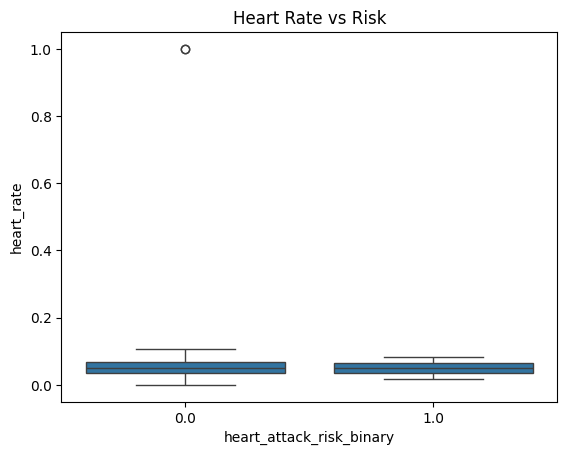

In [ ]:
sns.boxplot(x='heart_attack_risk_binary', y='heart_rate', data=train_data_copy)
plt.title('Heart Rate vs Risk')
plt.show()

Связи с целеввым признаком нет, аномалия встечается всего для двух строк, удалим выброс

In [ ]:
train_data_copy = train_data_copy[train_data_copy['heart_rate'] <= 0.2]

Удалим аналогичный выброс в тестовых данных, если он есть

In [ ]:
test_data_copy[test_data_copy['heart_rate'] > 0.2]

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
456,0.348315,0.49978,1.0,NaN,NaN,NaN,NaN,NaN,0.50211,3,NaN,NaN,NaN,0.49992,0.494889,0.494774,0.503603,NaN,0.504621,0.146245,0.003367,0.097971,1.0,0.490323,0.616279,9394


In [ ]:
test_data_copy = test_data_copy[test_data_copy['heart_rate'] <= 0.2]

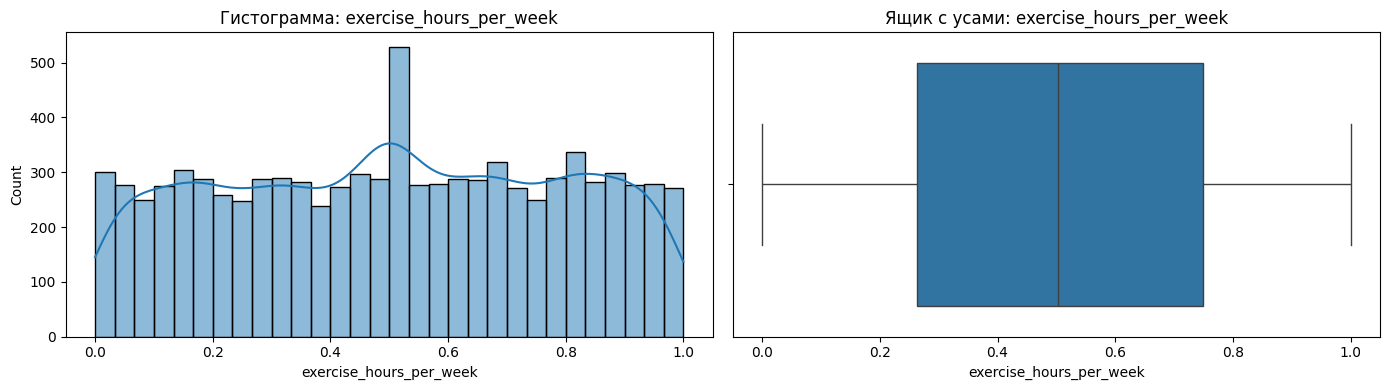

In [ ]:
plot_quantitative_feature(train_data_copy, 'exercise_hours_per_week')

Признак exercise_hours_per_week нормализован от 0 до 1, пик на 0.5 Выбросов нет

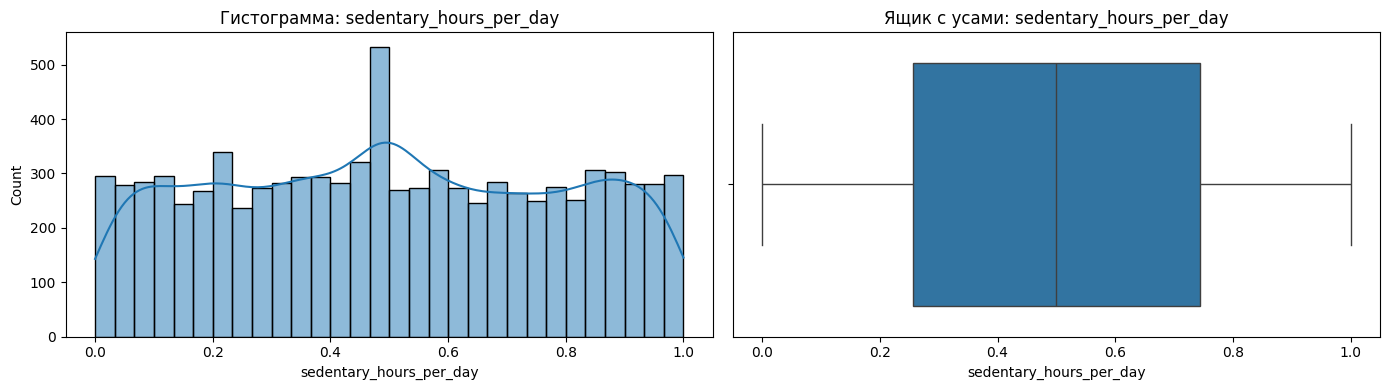

In [ ]:
plot_quantitative_feature(train_data_copy, 'sedentary_hours_per_day')

Признак sedentary_hours_per_day нормализован от 0 до 1, пик на 0.5 Выбросов нет

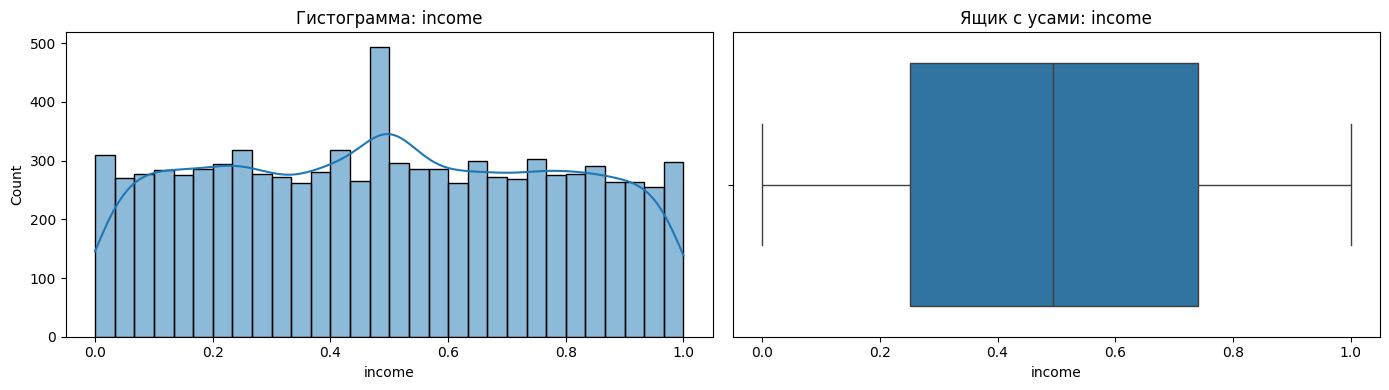

In [ ]:
plot_quantitative_feature(train_data_copy, 'income')

Признак income нормализован от 0 до 1, пик на 0.5 Выбросов нет

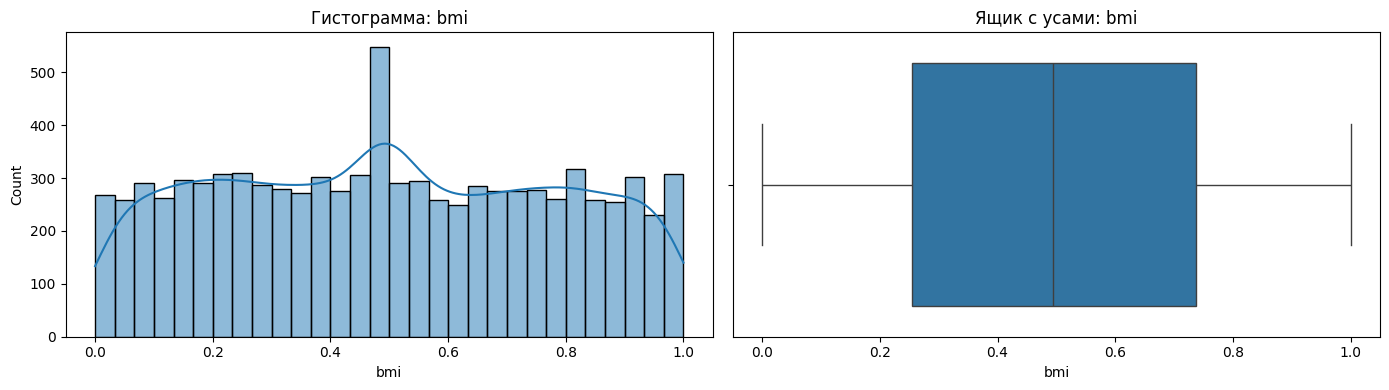

In [ ]:
plot_quantitative_feature(train_data_copy, 'bmi')

Признак bmi нормализован от 0 до 1, пик на 0.5 Выбросов нет

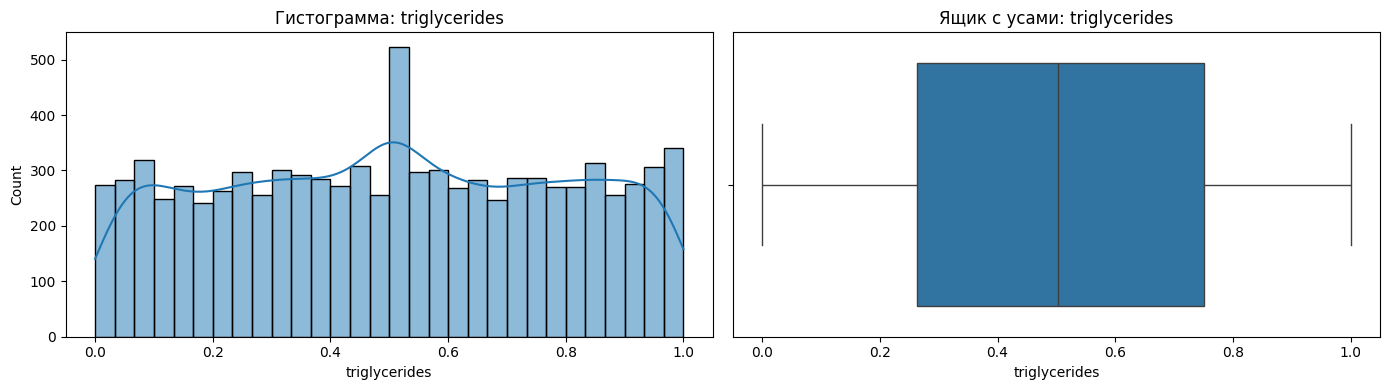

In [ ]:
plot_quantitative_feature(train_data_copy, 'triglycerides')

Признак triglycerides нормализован от 0 до 1, пик на 0.5 Выбросов нет

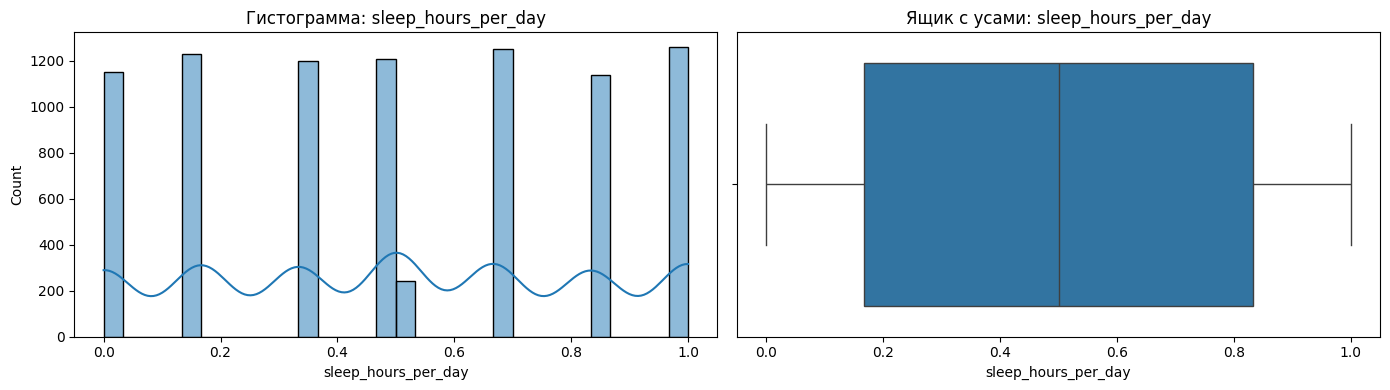

In [ ]:
plot_quantitative_feature(train_data_copy, 'sleep_hours_per_day')

Выбросов нет, но распределение дискретное, перенесём признак в дискретные. Значения часов сна нормализованы и закодированы

In [ ]:
quantitative_features = [
    'age', 'cholesterol', 'heart_rate', 'exercise_hours_per_week',
    'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides',
    'blood_sugar', 'ck-mb', 'troponin', 'systolic_blood_pressure', 'diastolic_blood_pressure'
]

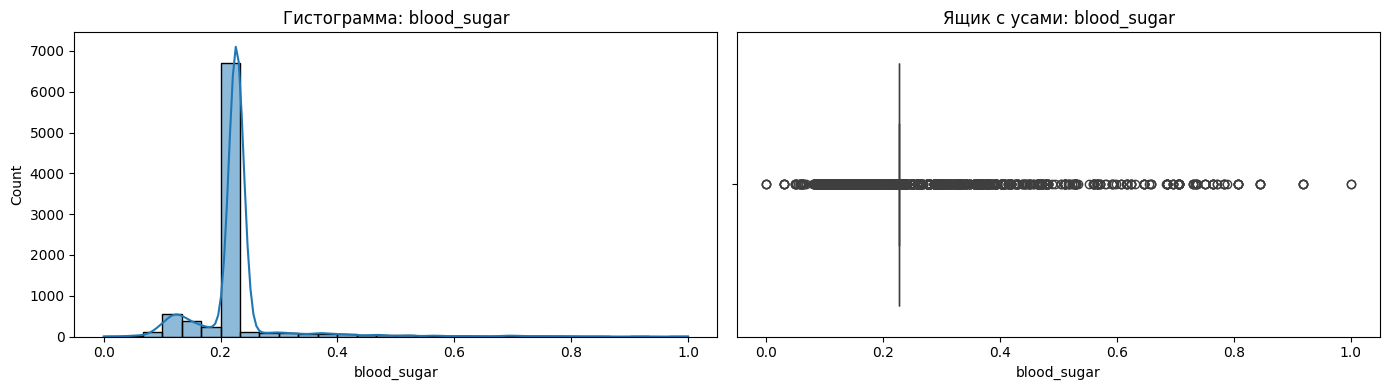

In [ ]:
plot_quantitative_feature(train_data_copy, 'blood_sugar')

Признак blood_sugar нормализован, распределение сильно скошено, очень много выбросов справа до 1. Основная масса значений около 0.2
Вероятно у большинства людей нормальный сахар, но у некоторых аномальный (возможно диабетики). Проверим связь с таргетом

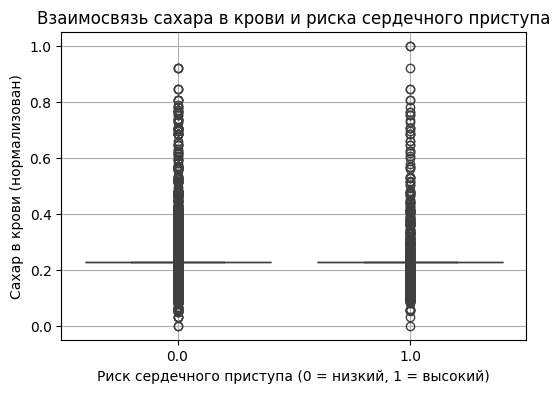

In [ ]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='heart_attack_risk_binary', y='blood_sugar', data=train_data_copy)
plt.title('Взаимосвязь сахара в крови и риска сердечного приступа')
plt.xlabel('Риск сердечного приступа (0 = низкий, 1 = высокий)')
plt.ylabel('Сахар в крови (нормализован)')
plt.grid()
plt.show()

Признак имеет много выбросов, но слабую связь с целевым (по крайней мере, визуально). Удалять их не стоит, тк это могут быть реальные показатели высокого сахара

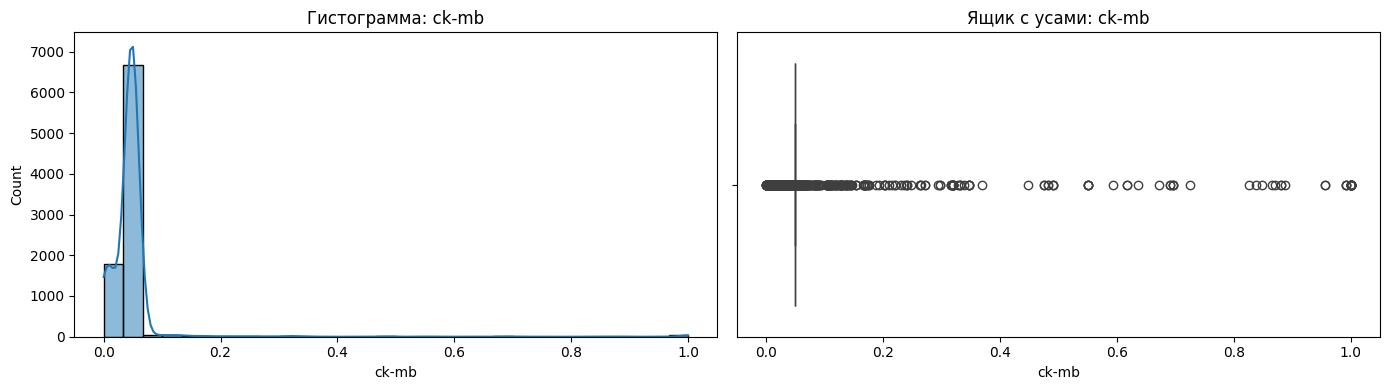

In [ ]:
plot_quantitative_feature(train_data_copy, 'ck-mb')

Распределение признака очень похоже на blood_sugar, проверим их на коллинеарность на корреляционном анализе данных. Выбросов много. Признак нормализован

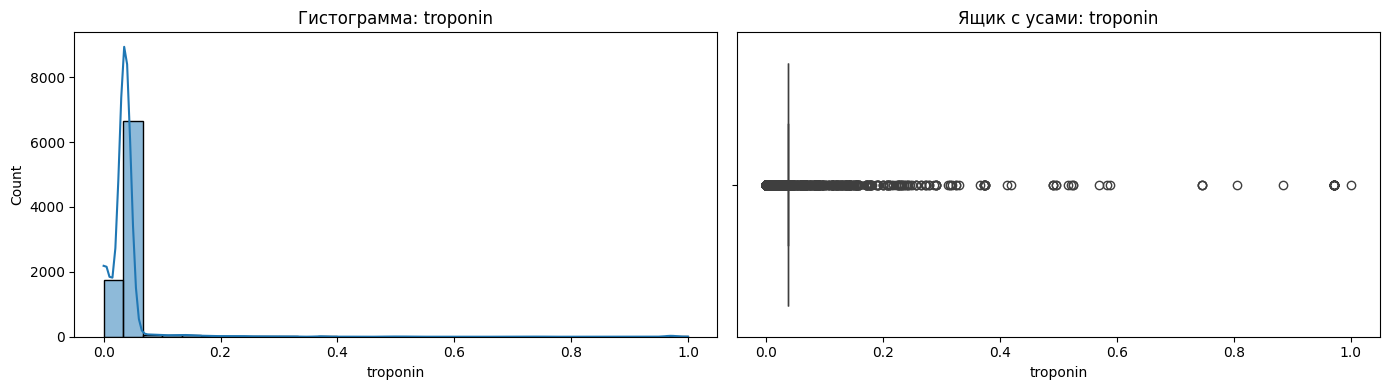

In [ ]:
plot_quantitative_feature(train_data_copy, 'troponin')

Распределение признака очень похоже на blood_sugar, проверим их на коллинеарность на корреляционном анализе данных. Выбросов много. Признак нормализован

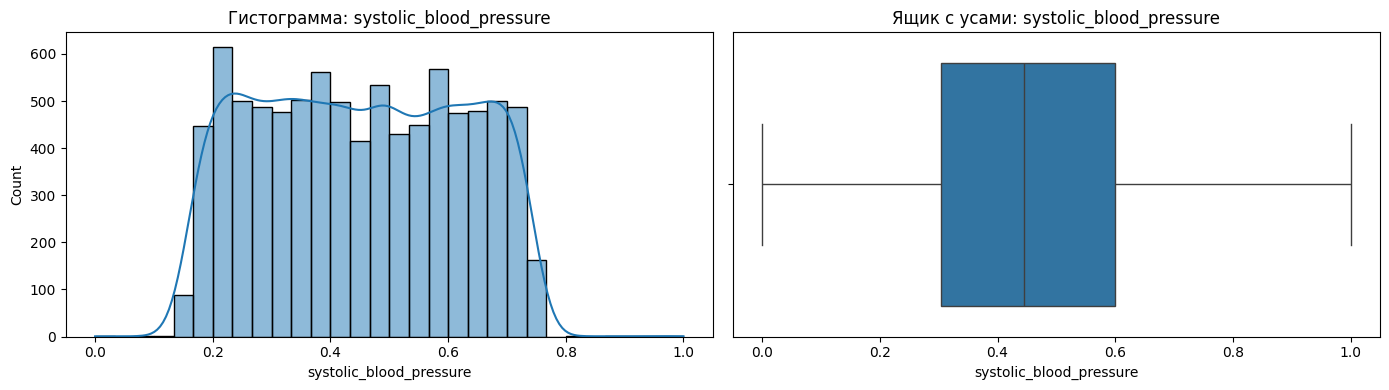

In [ ]:
plot_quantitative_feature(train_data_copy, 'systolic_blood_pressure')

Признак systolic_blood_pressure нормализован от 0 до 1, большинство значений сконцентрированы в интервале 0.02 – 0.08

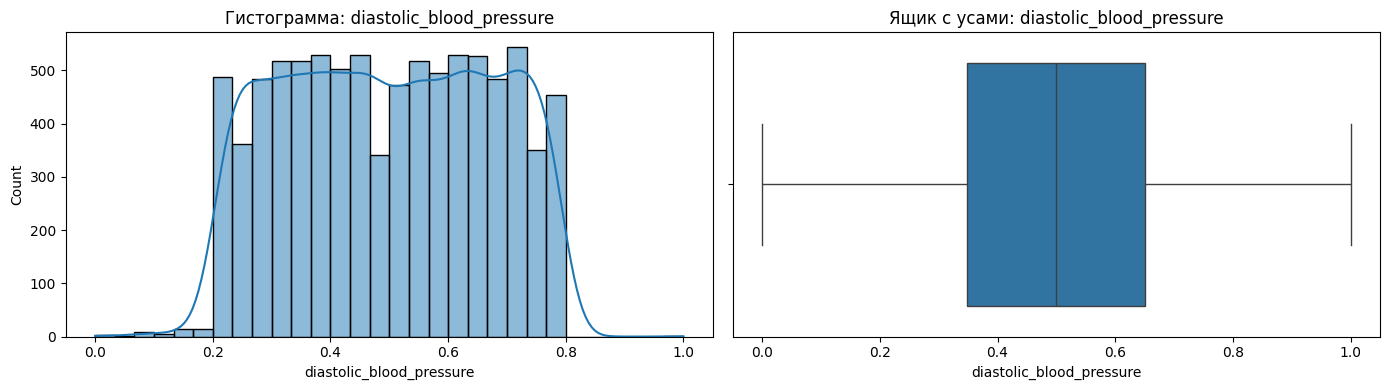

In [ ]:
plot_quantitative_feature(train_data_copy, 'diastolic_blood_pressure')

Проанализируем дискретные признаки, посмотрим сколько среди них пропусков

In [ ]:
for col in discrete_binary_features:
    print(f'{col}: {train_data_copy[col].isna().sum()} пропусков')

diabetes: 241 пропусков
family_history: 241 пропусков
smoking: 241 пропусков
obesity: 241 пропусков
alcohol_consumption: 241 пропусков
previous_heart_problems: 241 пропусков
medication_use: 241 пропусков
stress_level: 241 пропусков
physical_activity_days_per_week: 241 пропусков


Пропуски совпдают по всем признакам, похоже на систематическую ошибку в данных. Удалим пропуски, так как признаки дисретные и их рискованно заполнять нулями, это может исказить картину


In [ ]:
train_data_copy = train_data_copy.dropna(subset=discrete_binary_features)
print(train_data_copy.shape)

(8442, 27)


In [ ]:
print(train_data.shape)

(8685, 28)


Удалим пропуски в тестовых данных

In [ ]:
test_data_copy = test_data_copy.dropna(subset=discrete_binary_features)
print(test_data_copy.shape)

(935, 26)


In [ ]:
print(test_data.shape)

(966, 27)


In [ ]:
def plot_discrete_feature(df, feature):
    plt.figure(figsize=(14, 4))
    # количество наблюдений по значениям
    plt.subplot(1, 2, 1)
    sns.countplot(x=feature, data=df, order=sorted(df[feature].unique()))
    plt.title(f'Столбчатый-график: {feature}')
    plt.xlabel(feature)
    plt.ylabel('Количество')

    # распределение по значениям
    plt.subplot(1, 2, 2)
    sns.stripplot(x=feature, data=df, jitter=True, color='orange')
    plt.title(f'Распределение значений: {feature}')
    plt.xlabel(feature)

    plt.tight_layout()
    plt.show()

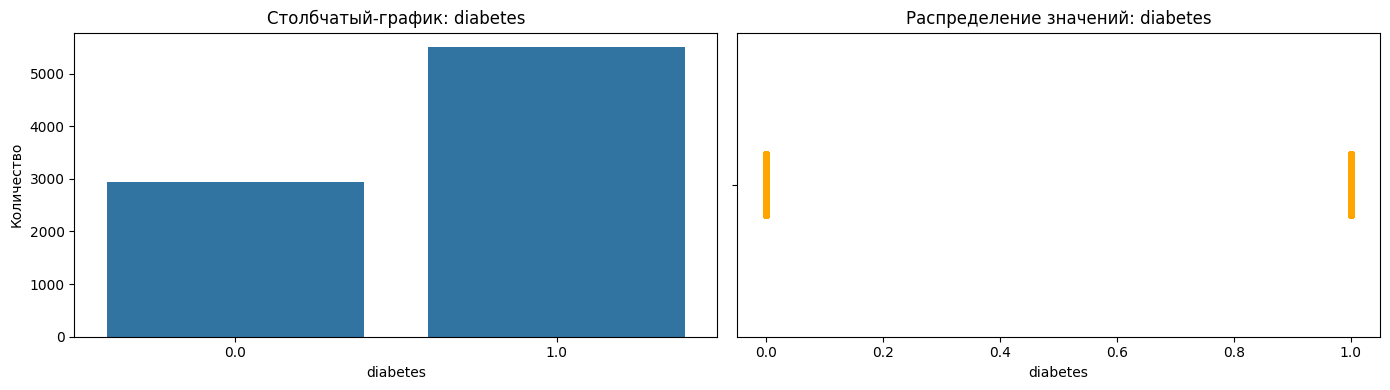

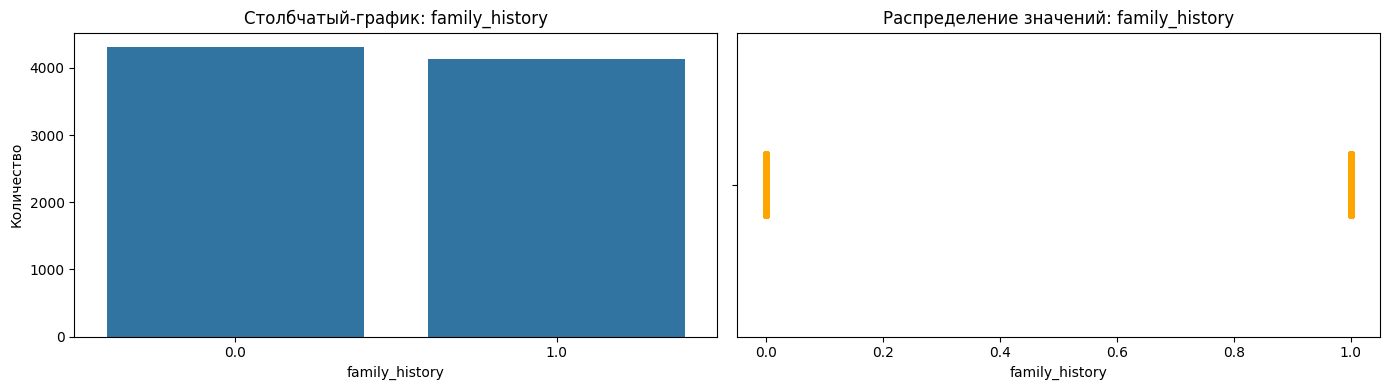

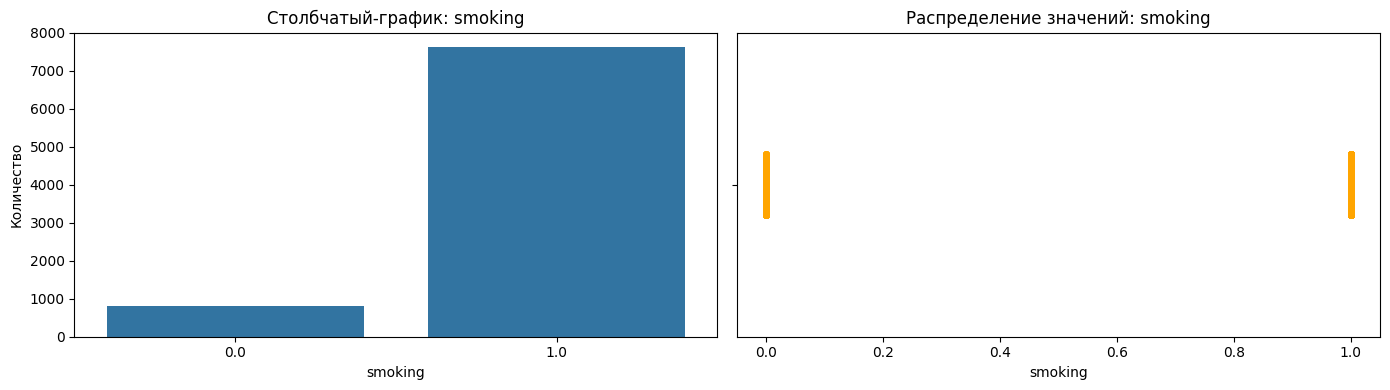

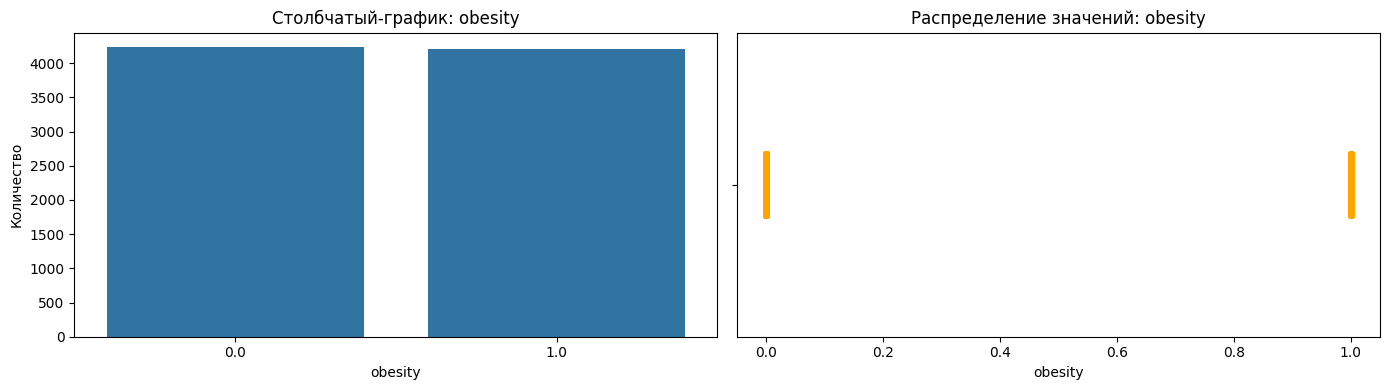

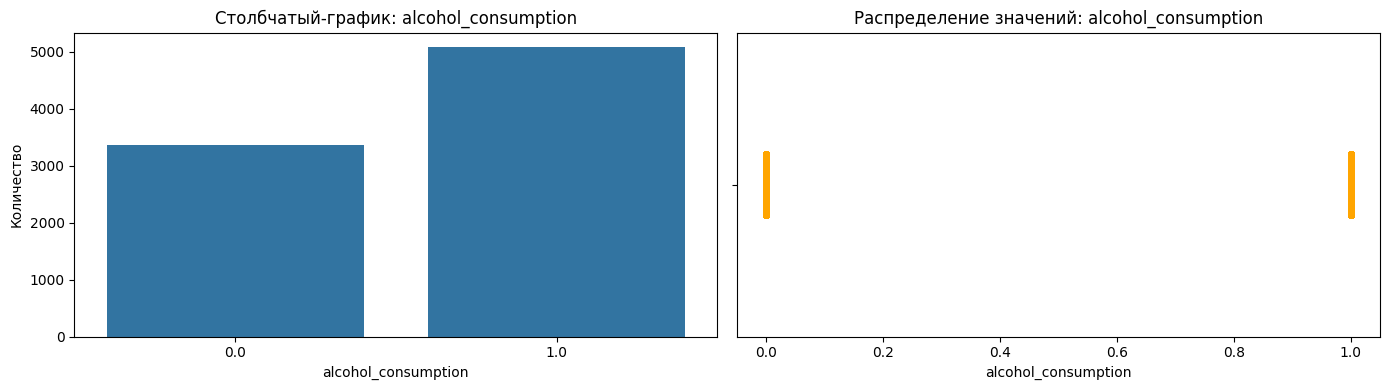

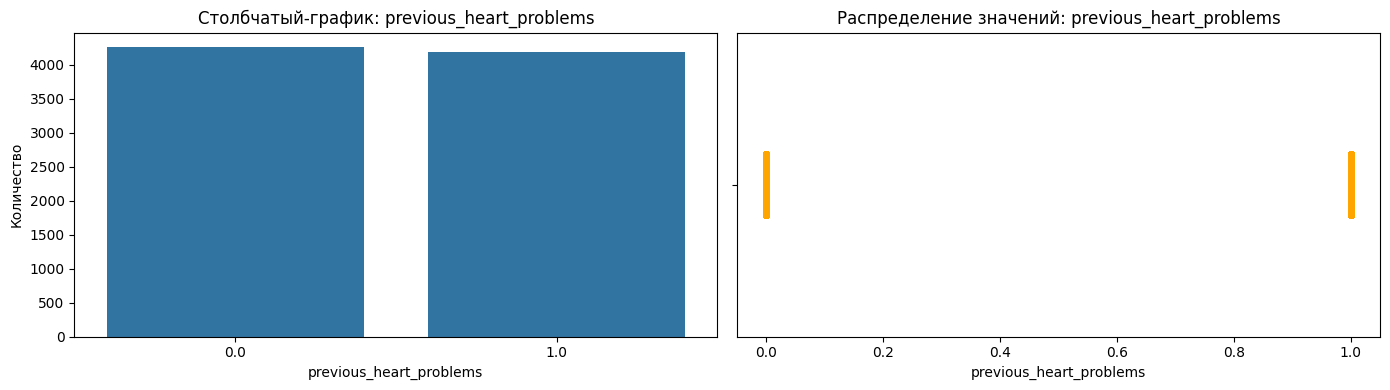

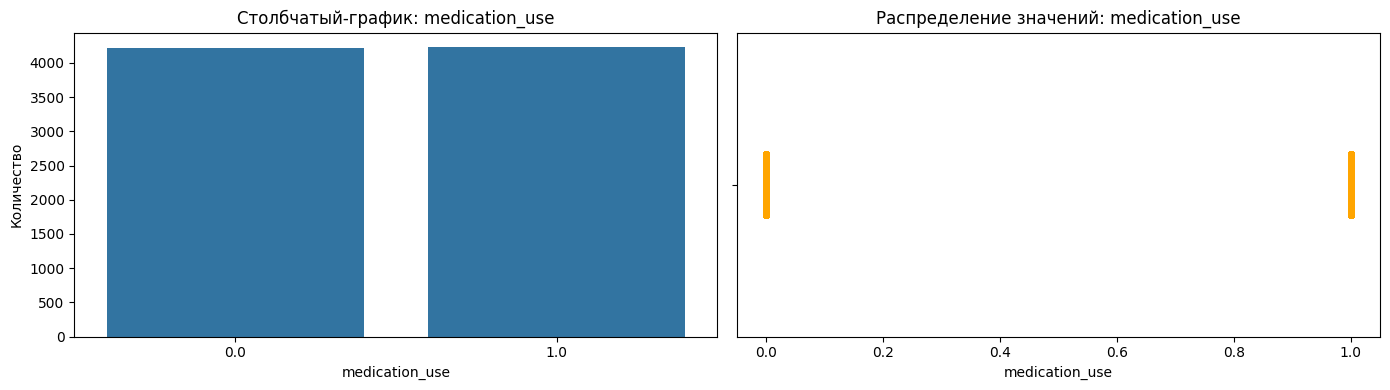

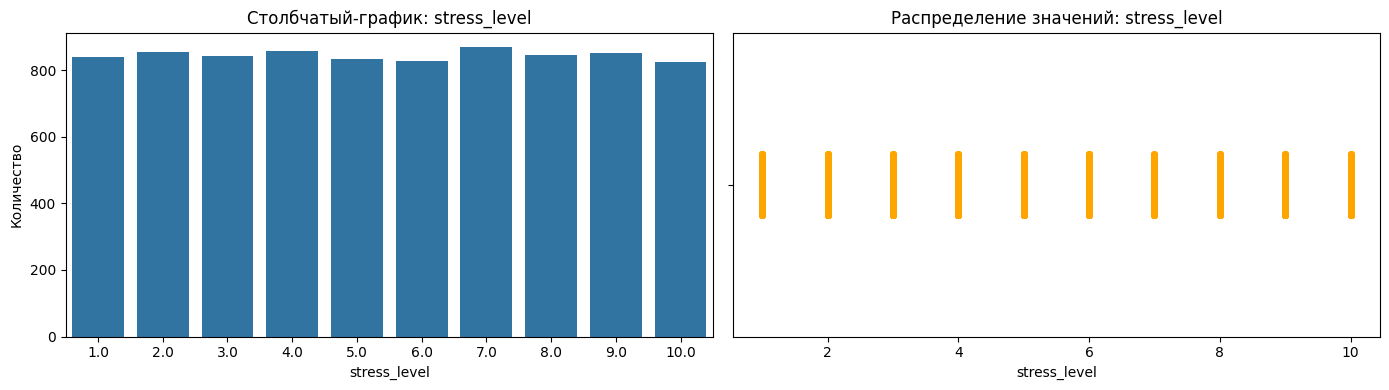

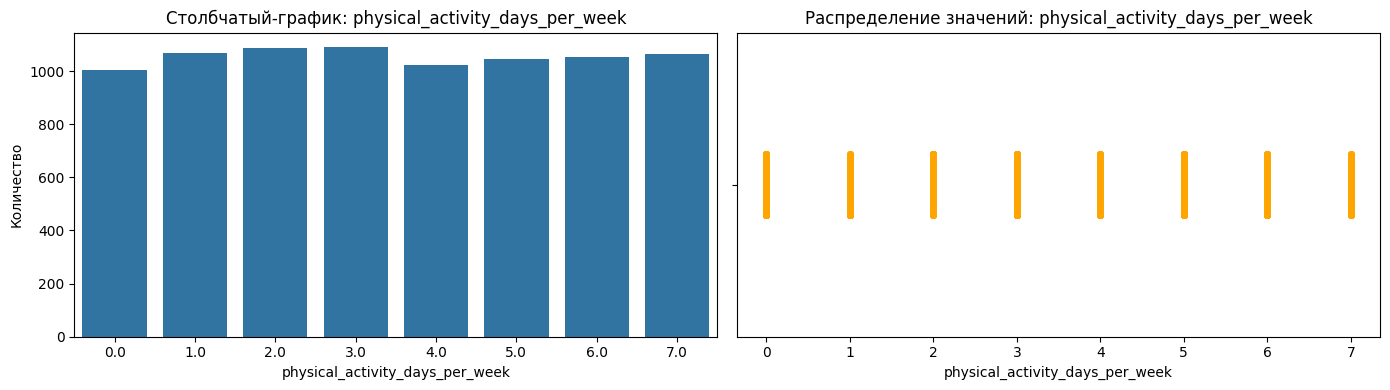

In [ ]:
for feature in discrete_binary_features:
    plot_discrete_feature(train_data_copy, feature)

Распределения варьируются: у некоторых сбалансированы (примерно одинаковое число 0 и 1), у других — выражен дисбаланс (например, diabetes, smoking, alcohol_consumption) с преобладанием одного класса.<br>
Последние два признака — дискретные количественные (но не бинарные):<br>
stress_level: принимает значения от 1 до 10, распределение равномерное. <br>
physical_activity_days_per_week: принимает целые значения от 0 до 7 — это тоже дискретный, порядковый признак. Может влиять на риск сердечных заболеваний (например, отсутствие активности = 0).

Теперь построим графики для категориальных признаков

In [ ]:
def plot_categorical_feature(df, feature):
    plt.figure(figsize=(12, 5))

    # Bar plot
    plt.subplot(1, 2, 1)
    sns.countplot(x=feature, data=df, order=df[feature].value_counts().index)
    plt.title(f'Столбчатая диаграмма: {feature}')
    plt.xlabel(feature)
    plt.ylabel('Количество')
    plt.xticks(rotation=30)

    # Pie chart
    plt.subplot(1, 2, 2)
    df[feature].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
    plt.title(f'Круговая диаграмма: {feature}')
    plt.ylabel('')

    plt.tight_layout()
    plt.show()

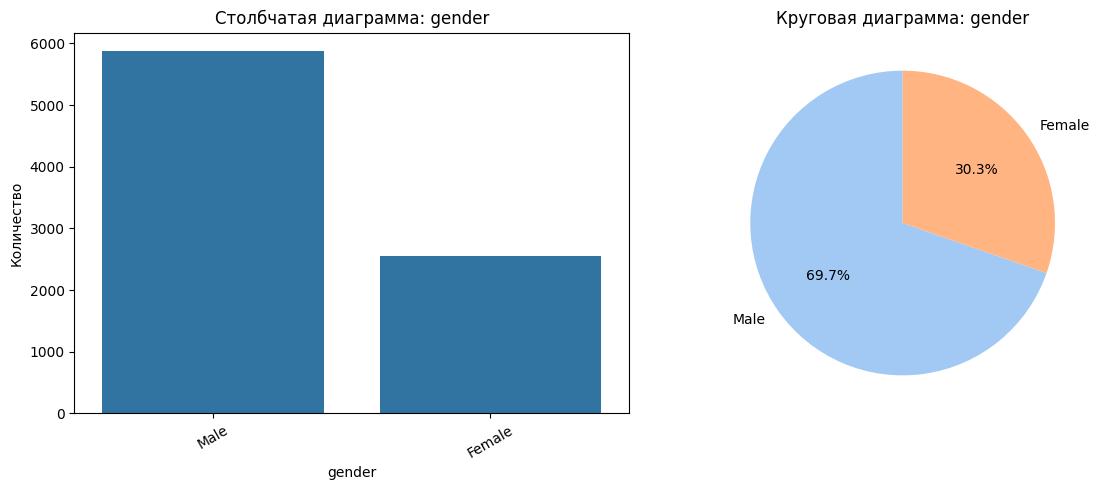

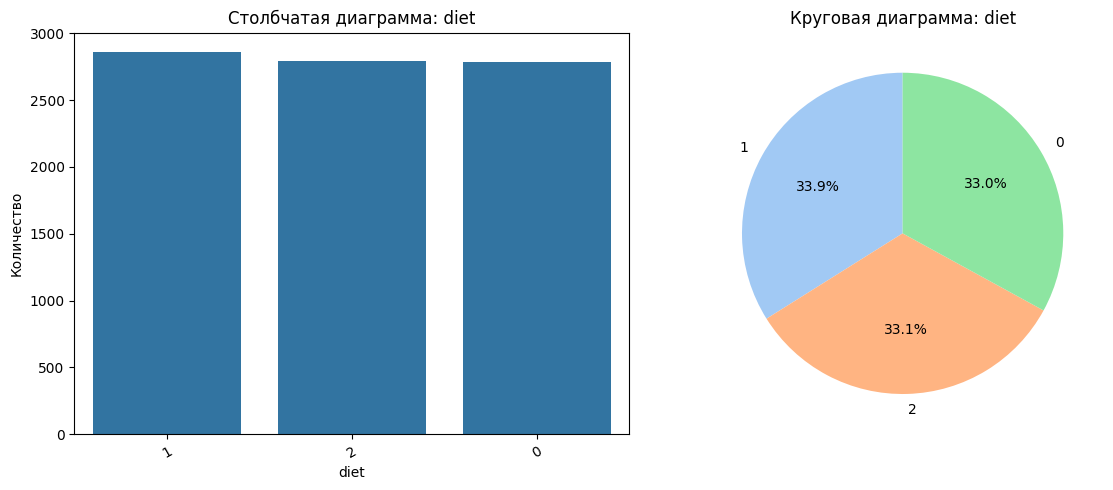

In [ ]:
for feature in categorical_features:
    plot_categorical_feature(train_data_copy, feature)

Мужчин почти в 2.3 раза больше, чем женщин (≈70% vs 30%), признак gender закодирован как строка, в отличаи от всех остальных признаков. Закодируем его бинарно

In [ ]:
train_data_copy['gender'] = train_data_copy['gender'].map({'Male': 0, 'Female': 1})
test_data_copy['gender'] = test_data_copy['gender'].map({'Male': 0, 'Female': 1})


Поправим тип данных

In [ ]:
train_data_copy['gender'] = pd.to_numeric(train_data_copy['gender'], errors='coerce').astype('Int64')
test_data_copy['gender'] = pd.to_numeric(test_data_copy['gender'], errors='coerce').astype('Int64')

В ходе <b>исследовательского анализа данных</b> были построены графики распределения для количественных, категориальных и дискретных признаков. Были проанализированы распределения, выбросы, баланс классов и нормализация.<br/>
Выбросы выявлены в признаках: blood_sugar, ck-mb, troponin. Сохранены, так как отражают потенциально важную клиническую информацию (например, острые состояния).<br/>
Выбросы удалены для heart_rate в тренировочной и тестовой выборках. Два выброса не коррелировали с целевым признаком и сопровождались множественными пропусками<br/>
Пропуски обнаружены в одних и тех же дискретных признаках  в train и test:'diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 'previous_heart_problems', 'medication_use', 'stress_level', 'physical_activity_days_per_week', 'sleep_hours_per_day'<br/>
Пропуски удалены из обеих выборок, поскольку они затрагивают те же признаки и признаки бинарные, поэтому заполнение нулями может исказить интерпретацию<br/>
<b>В результате исследовательского анализа данных были выявлены следующие особенности:</b><br>
Большинство признаков нормализованы (значения в диапазоне 0–1)<br/>
Распределения нормальные, кроме: blood_sugar, ck-mb, troponin — сильно скошены, возможные медицинские показатели с длинными хвостами<br/>
Дисбаланс классов замечен в бинарных признаках, таких как gender, diabetes, smoking, alcohol_consumption
Признак gender был приведён к бинарному кодированию, установлен тип данных int

<h2>3. Корреляционный анализ признаков в датасете</h2>
Проведём корреляционный анализ признаков. Сделаем выводы о мультиколлинеарности и при необходимости устраним её<br>
Посмотрим, есть ли линейные или сложные зависимости между признаками, с учётом того что целевой признак Heart Attack Risk (Binary). Для этого построим диаграмму рассеиния

Построим тепловую карту корреляции

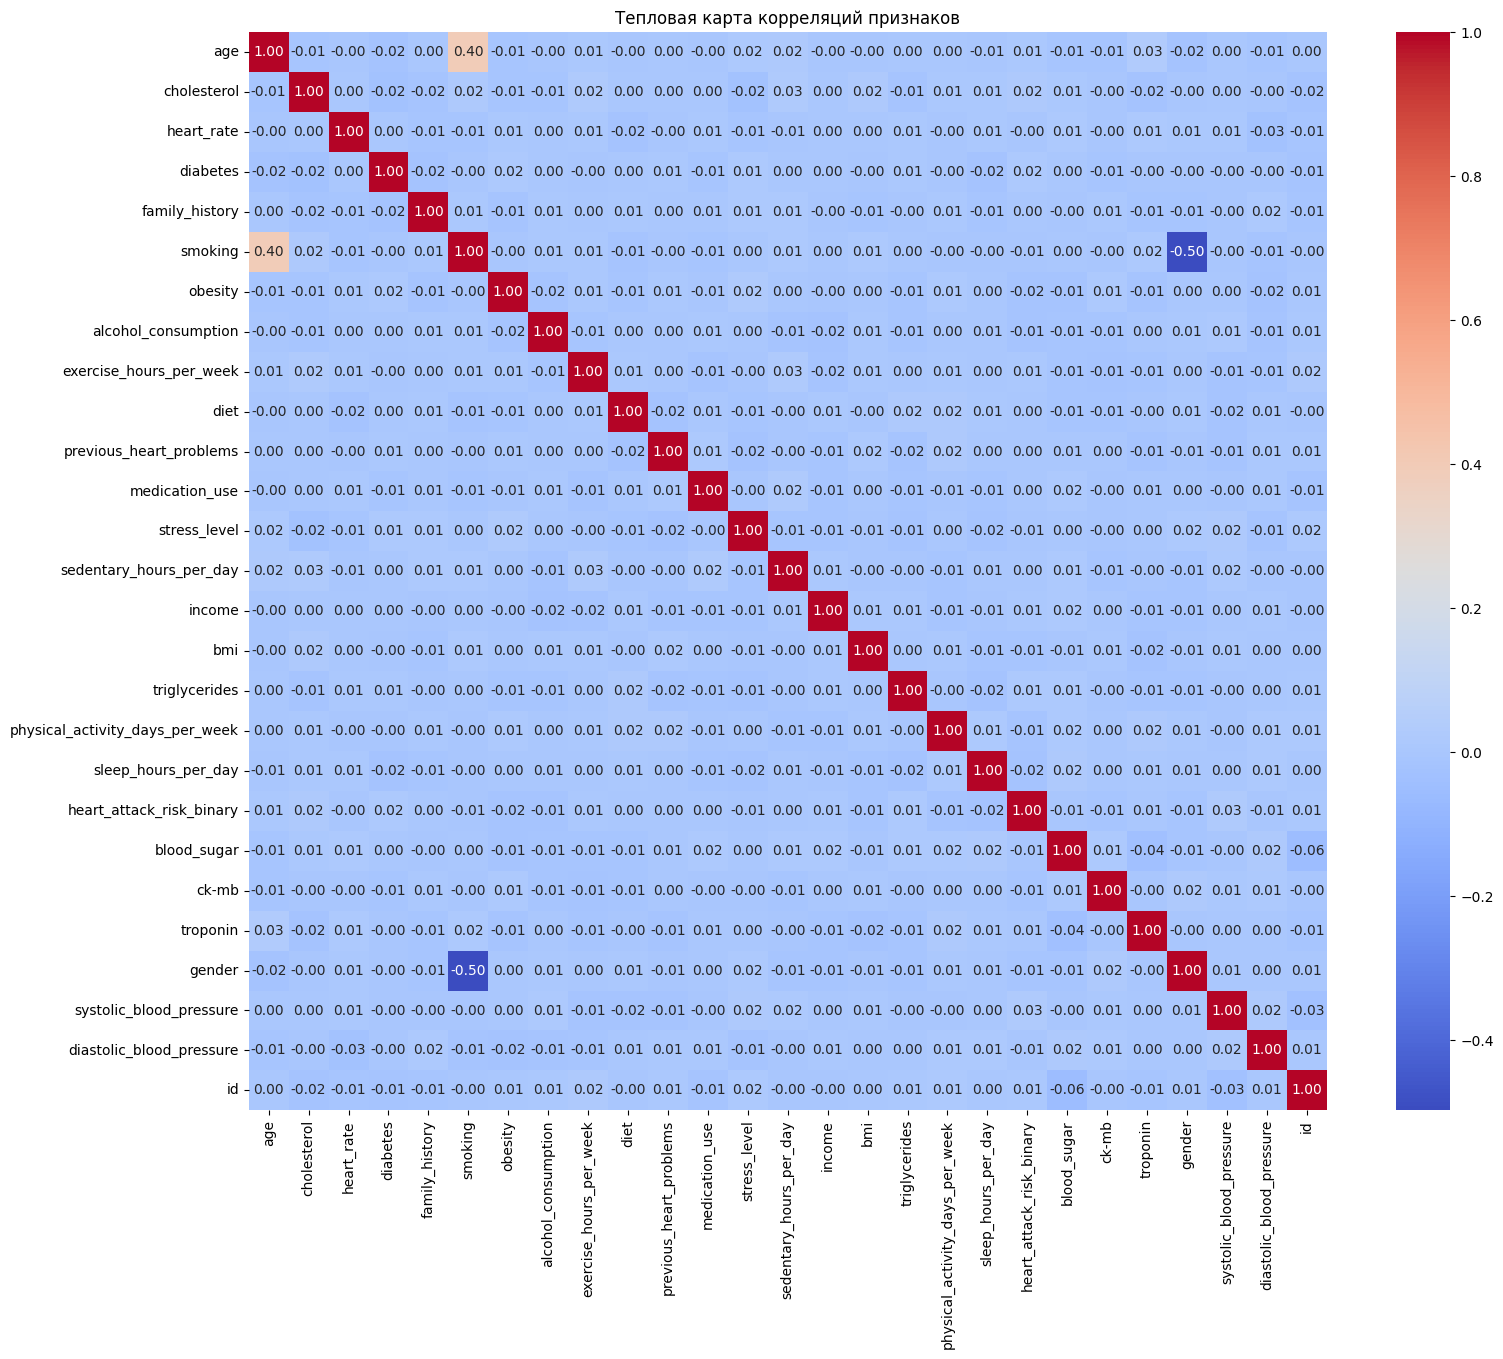

In [ ]:
plt.figure(figsize=(18, 14))
correlation_matrix = train_data_copy.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Тепловая карта корреляций признаков')
plt.show()

Сильной мультиколлинеарности нет. Все признаки находятся в пределах от –0.5 до +0.4. Максимум: age ↔ smoking = 0.40, gender ↔ smoking = –0.50 — умеренная корреляция.<br/>
Взаимосвязи с таргетом очень слабые, все значения близки к нулю, максимум ~±0.02.<br/>
Это указывает на слабую линейную связь, что: либо говорит о важности нелинейных зависимостей, либо данные достаточно хорошо сбалансированы и сложны для линейной модели.<br/>
systolic_blood_pressure ↔ diastolic_blood_pressure: ≈ 0.4 — ожидаемо.<br/>
gender ↔ smoking: –0.50 — мужчины курят чаще.<br/>
age ↔ smoking: +0.40 — старшие участники чаще курят.<br/>

Перейдём к построению диаграм рассеяния, чтобы проверить прищнаки на потенциальную утечку данных

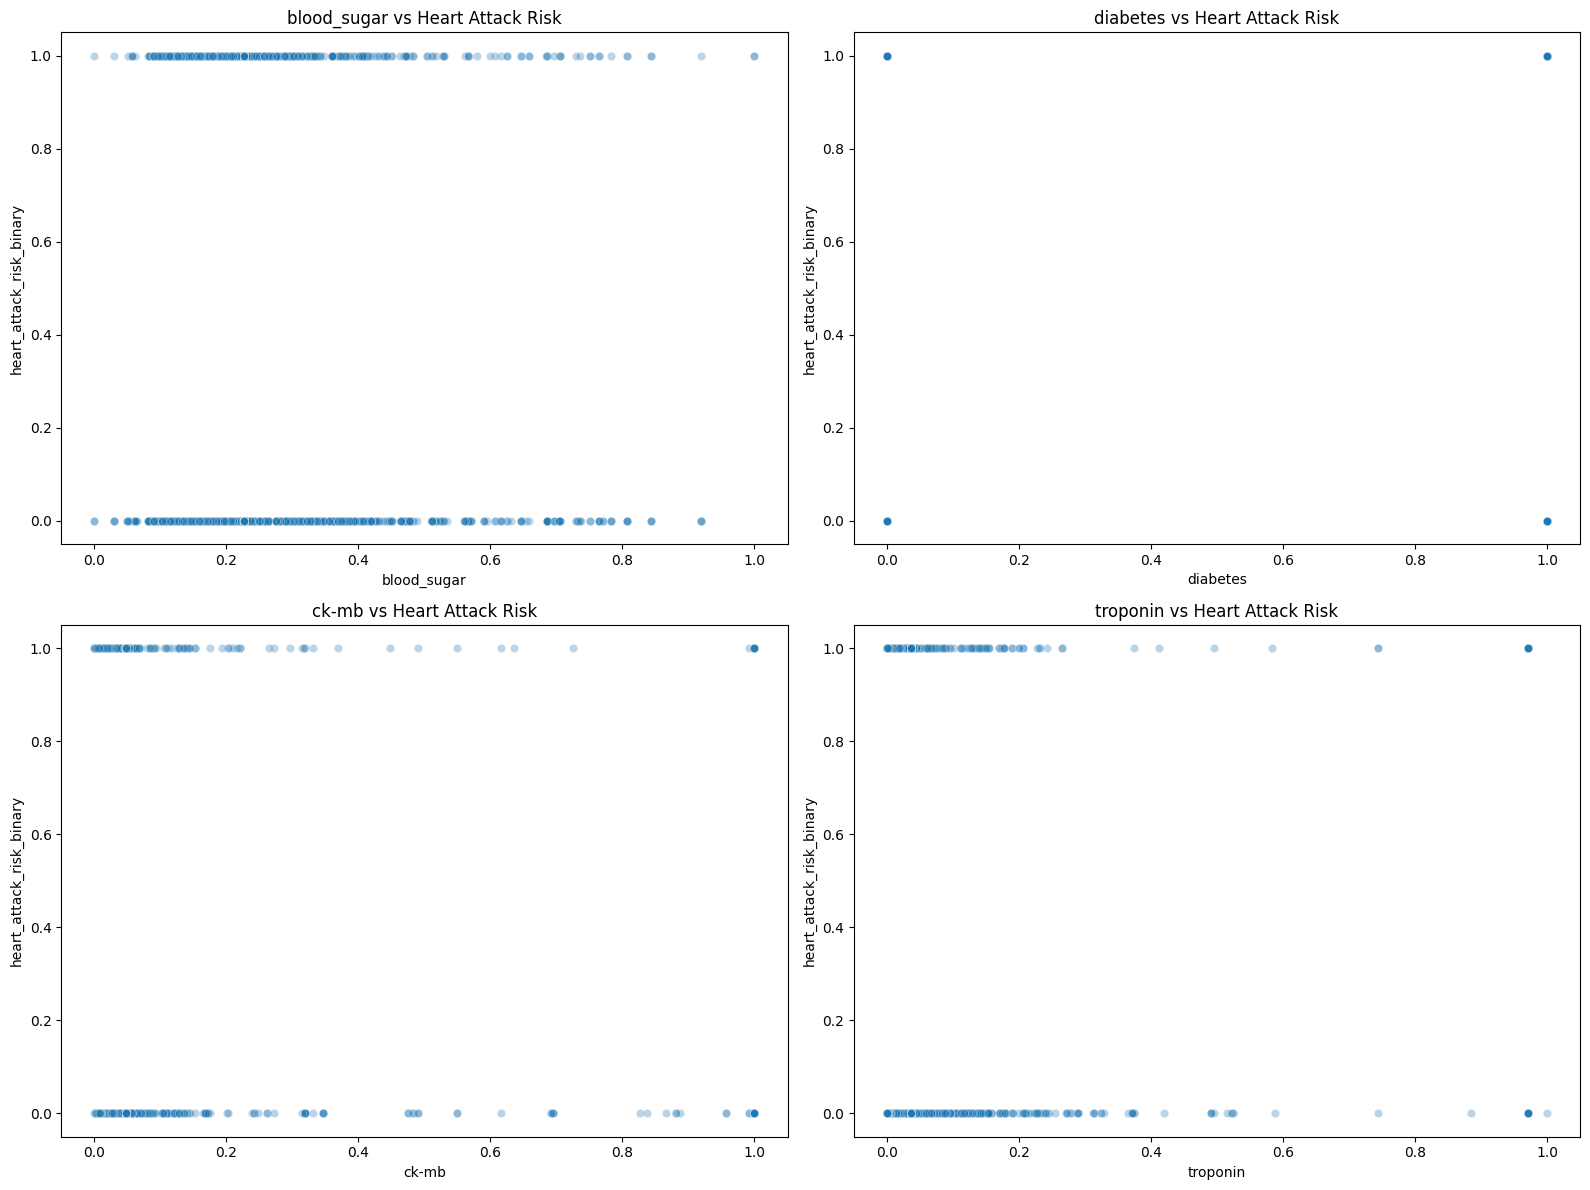

In [ ]:
# Перечень "похожих" признаков для анализа с таргетом
similar_features = ['blood_sugar', 'diabetes', 'ck-mb', 'troponin']

# Построение диаграмм рассеяния между этими признаками и целевым
plt.figure(figsize=(16, 12))
for i, feature in enumerate(similar_features, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(data=train_data_copy, x=feature, y='heart_attack_risk_binary', alpha=0.3)
    plt.title(f'{feature} vs Heart Attack Risk')
    plt.xlabel(feature)
    plt.ylabel('heart_attack_risk_binary')
plt.tight_layout()
plt.show()

blood_sugar vs heart_attack_risk_binary:

Распределение скошено влево.
Есть случаи с высоким уровнем сахара, но чёткой границы между классами нет — утечки не наблюдается, но возможно нелинейная зависимость.

diabetes vs heart_attack_risk_binary:

Бинарный признак.

У пациентов с диабетом чаще встречается 1 (высокий риск), но признак не является дублирующим blood_sugar — скорее, дополняет его (категоризация vs непрерывное значение).

ck-mb и troponin vs heart_attack_risk_binary:

Поведение схоже с blood_sugar: выбросы и хвосты справа.

Уровень маркеров выше у пациентов с высоким риском, но границы размазаны — также утечки нет, но они явно информативны

Несмотря на логическое сходство, признаки дополняют друг друга, но не дублируют, утечки данных не наблюдается

В ходе <b>корреляционного анализа</b> были построены диаграммы рассеяния и матрица корреляции. Мультиколлинеарность не выявлена — коэффициенты корреляции между признаками находятся в допустимом диапазоне, отсутствуют признаки с избыточной взаимосвязью.
<br> <b>Основные выводы:</b><br>
Сильной мультиколлинеарности не обнаружено: все значения коэффициентов корреляции лежат в пределах от –0.5 до +0.4.<br>
Максимальные взаимосвязи:<br>
age ↔ smoking = +0.40 — старшие участники чаще курят;<br>
gender ↔ smoking = –0.50 — мужчины курят чаще;<br>
systolic_blood_pressure ↔ diastolic_blood_pressure ≈ +0.4 — физиологически ожидаемая зависимость.<br>
Связи с целевым признаком (heart_attack_risk_binary) крайне слабы, максимум ~±0.02, что может указывать на:<br>
важность нелинейных зависимостей;<br>
отсутствие простых линейных паттернов, требующих более сложных моделей.<br>
<b>Отдельные наблюдения по потенциальным "утекающим" признакам:</b><br>
blood_sugar ↔ diabetes: корреляция ≈ 0.003 — признаки независимы, один непрерывный, другой бинарный. Утечки нет, но возможна взаимодополняемость.<br>
blood_sugar ↔ heart_attack_risk_binary: распределение скошено, у высокорисковых пациентов значения выше, но чёткой границы нет.<br>
ck-mb, troponin ↔ heart_attack_risk_binary: признаки показывают повышенные значения у группы с высоким риском, однако разделение не чёткое, утечка отсутствует, признаки информативны.<br>

<h2>3. Обучение моделей</h2>

В ходе работы будут обучены три модели: RandomForest, LogisticRegression и CatBoostClassifier<br>
Обработка качественных и количественных признаков, при этом, будет проходить в раздельных пайплайнах<br>
В качестве метрики будем использовать ROC-AUC или F1-score так как перед нами задача бинарной классификации, узнать есть ли риск сердечного приступа, или нет. То есть интерес представляют и точность, и полнота. Ошибки первого и второго рода могут нести разный вес.<br>
С помощью этих метрики мы сможем корректно оценить способность моделей разделять классы

Разобъём данные на выборки

In [ ]:
categorical_features = categorical_features
numerical_features = quantitative_features  # Уже нормализованы
binary_features = discrete_binary_features  # 0/1

target_col = 'heart_attack_risk_binary'

X = train_data_copy.drop(columns=['id', target_col])
y = train_data_copy[target_col]

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)


X_train.shape, X_test.shape

((6331, 25), (2111, 25))

Создадим пайплайны

In [ ]:
# 1. Создадим ColumnTransformer для LogReg и RF (CatBoost не требует кодирования)
logreg_rf_preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('bin', 'passthrough', binary_features),
    ('num', 'passthrough', numerical_features)
])

# 2. Финальный пайпайн
pipe_final = Pipeline([
    ('preprocessor', logreg_rf_preprocessor),
    ('model', LogisticRegression())
])

# 3. Гиперпараметры
param_grid = [
    {
        'model': [LogisticRegression(solver='liblinear', penalty='l1', random_state=RANDOM_STATE)],
        'model__C': [0.01, 0.1, 1, 10, 100],
    },
    {
        'model': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'model__n_estimators': [50, 100, 150],
        'model__max_depth': [3, 5, 10, None],
        'model__min_samples_split': [2, 5, 10],
    }
]

Обучим и сравним модели

In [ ]:
# 4. RandomizedSearchCV (CatBoost обучим отдельно)
random_search = RandomizedSearchCV(
    pipe_final,
    param_distributions=param_grid,
    scoring='roc_auc',
    n_iter=10,
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

# 5. Обучим RandomSearch
random_search.fit(X_train, y_train)

# 8. Отдельно обучим CatBoost
cat_features_idx = [X_train.columns.get_loc(col) for col in categorical_features]
catboost_model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)
catboost_model.fit(X_train, y_train, cat_features=cat_features_idx)
catboost_score = roc_auc_score(y_test, catboost_model.predict_proba(X_test)[:, 1])

print('Лучшая модель и её параметры:\n\n', random_search.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', random_search.best_score_)
print('Метрика catboost на тренировочной выборке:', catboost_score)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'diet']),
                                                 ('bin', 'passthrough',
                                                  ['diabetes', 'family_history',
                                                   'smoking', 'obesity',
                                                   'alcohol_consumption',
                                                   'previous_heart_problems',
                                                   'medication_use',
                                                   'stress_level',
                                                   'physical_activity_days_per_week']),
                                                 ('num

И RandomForestClassifier и CatBoost показали низкое качество на тренировочной выборке,ROC-AUC 0.5. Проведём SHAP-анализ чтобы понять, какие признаки действительно важны

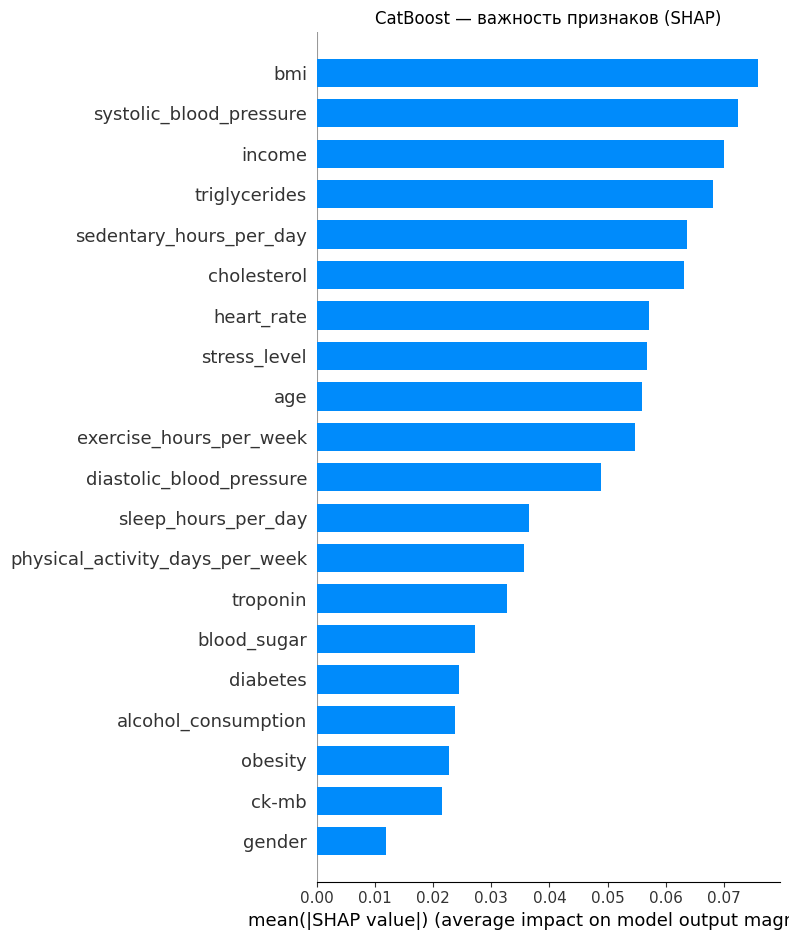

In [ ]:
# SHAP для CatBoost
explainer_catboost = shap.TreeExplainer(catboost_model)
shap_values_catboost = explainer_catboost.shap_values(X_train)

# Визуализация важности признаков
plt.figure(figsize=(14, 6))
shap.summary_plot(shap_values_catboost, X_train, plot_type="bar", show=False)
plt.title("CatBoost — важность признаков (SHAP)")
plt.tight_layout()
plt.show()

Теперь посмотрим на важные признаки для RandomForestClassifier

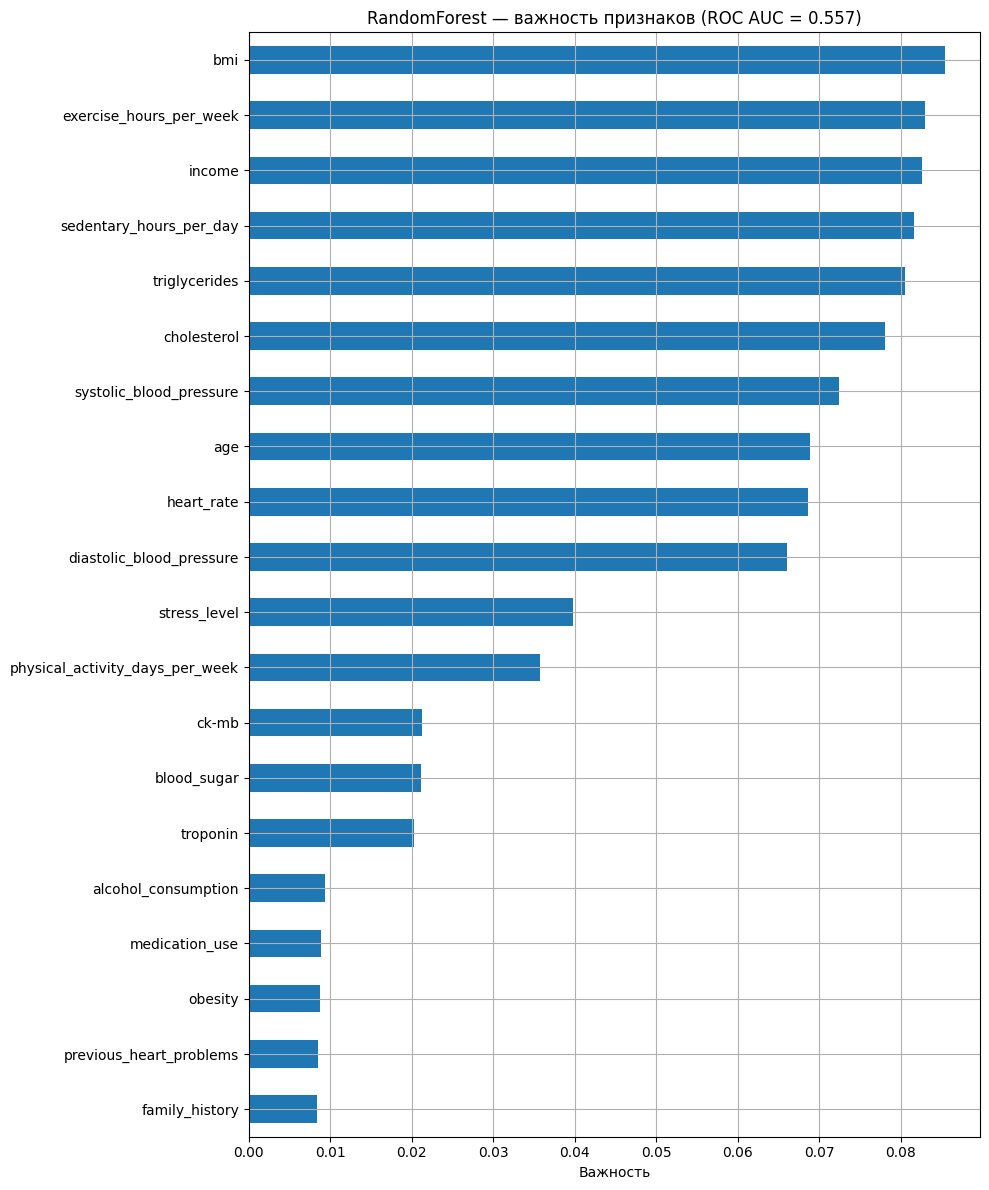

In [ ]:
# Получим лучшую модель
best_pipeline = random_search.best_estimator_
rf_model = best_pipeline.named_steps['model']
preprocessor = best_pipeline.named_steps['preprocessor']

# Получаем имена категориальных фичей после OHE
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

# Остальные фичи были пропущены (passthrough)
bin_feature_names = binary_features
num_feature_names = numerical_features

# Объединяем итоговые имена всех признаков
all_feature_names = list(chain(ohe_feature_names, bin_feature_names, num_feature_names))

# Получаем важности признаков
rf_importances = pd.Series(rf_model.feature_importances_, index=all_feature_names).sort_values(ascending=False)

# Строим график
plt.figure(figsize=(10, 12))
rf_importances.head(20).plot(kind='barh')
plt.title(f'RandomForest — важность признаков (ROC AUC = {random_search.best_score_:.3f})')
plt.xlabel('Важность')
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

Таким образом можно выделить 10 признаков, оказывающих наибольшее влияние на обе модели:<br/>
bmi<br/>
income<br/>
systolic_blood_pressure<br/>
triglycerides<br/>
sedentary_hours_per_day<br/>
cholesterol<br/>
exercise_hours_per_week<br/>
heart_rate<br/>
age<br/>
stress_level<br/>
<br/>
Эти признаки стабильно показывают высокую важность в обеих моделях и отражают как физическое состояние (bmi, давление, пульс), так и образ жизни (доход, активность, стресс)

Подготовим признаки, выделив топ 10 по SHAP и разобъём выборку

In [ ]:
# Топ-10 признаков по SHAP
top_10_features = [
    'bmi',
    'income',
    'systolic_blood_pressure',
    'triglycerides',
    'sedentary_hours_per_day',
    'cholesterol',
    'exercise_hours_per_week',
    'heart_rate',
    'age',
    'stress_level' # этот — дискретный бинарный
]

# Обновим списки по типам
numerical_features_top = [
    'bmi', 'income', 'systolic_blood_pressure', 'triglycerides',
    'sedentary_hours_per_day', 'cholesterol', 'exercise_hours_per_week',
    'heart_rate', 'age'
]

binary_features_top = ['stress_level']
categorical_features_top = []  # нет категориальных среди топ-10

# Целевая переменная
target_col = 'heart_attack_risk_binary'

# Разделим выборки

X = train_data_copy[top_10_features]
y = train_data_copy[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)


Соберём пайплайны и обучим модели

In [ ]:
logreg_rf_preprocessor = ColumnTransformer([
    ('bin', 'passthrough', binary_features_top),
    ('num', 'passthrough', numerical_features_top)
])

# === Общий пайплайн ===

pipe_final = Pipeline([
    ('preprocessor', logreg_rf_preprocessor),
    ('model', LogisticRegression())  # заглушка, будет меняться в RandomizedSearch
])

# === Гиперпараметры ===

param_grid = [
    {
        'model': [LogisticRegression(solver='liblinear', penalty='l1', random_state=RANDOM_STATE)],
        'model__C': [0.01, 0.1, 1, 10, 100],
    },
    {
        'model': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'model__n_estimators': [50, 100, 150],
        'model__max_depth': [3, 5, 10, None],
        'model__min_samples_split': [2, 5, 10],
    }
]

# === RandomizedSearchCV для LogReg и RF ===

random_search = RandomizedSearchCV(
    pipe_final,
    param_distributions=param_grid,
    scoring='roc_auc',
    n_iter=10,
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

random_search.fit(X_train, y_train)

# === CatBoost (без препроцессинга) ===

catboost_model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)
catboost_model.fit(X_train, y_train)  # нет категориальных => cat_features не нужен
catboost_score = roc_auc_score(y_test, catboost_model.predict_proba(X_test)[:, 1])

# === Вывод результатов ===

print('Лучшая модель и её параметры:\n\n', random_search.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', random_search.best_score_)
print('Метрика catboost на тренировочной выборке:', catboost_score)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('bin', 'passthrough',
                                                  ['stress_level']),
                                                 ('num', 'passthrough',
                                                  ['bmi', 'income',
                                                   'systolic_blood_pressure',
                                                   'triglycerides',
                                                   'sedentary_hours_per_day',
                                                   'cholesterol',
                                                   'exercise_hours_per_week',
                                                   'heart_rate', 'age'])])),
                ('model',
                 RandomForestClassifier(min_samples_split=10, n_estimators=150,
                                        ra

Предсказания моделей на тренировочной выборке по прежнему практически случайные, добавим новые признаки в тренировочные и тестовые ланные:<br/>
Индекс риска по стилю жизни: lifestyle_risk = smoking + alcohol_consumption + obesity<br/>
<br/>
Физическая активность: active_score = exercise_hours_per_week - sedentary_hours_per_day<br/>
<br/>
Давление: pulse_pressure = systolic - diastolic<br/>
<br/>
Возрастные группы<br/>

In [ ]:
# 1. Индекс риска по стилю жизни
train_data_copy['lifestyle_risk'] = (
    train_data_copy['smoking'] +
    train_data_copy['alcohol_consumption'] +
    train_data_copy['obesity']
)

test_data_copy['lifestyle_risk'] = (
    test_data_copy['smoking'] +
    test_data_copy['alcohol_consumption'] +
    test_data_copy['obesity']
)

# 2. Физическая активность
train_data_copy['active_score'] = (
    train_data_copy['exercise_hours_per_week'] -
    train_data_copy['sedentary_hours_per_day']
)

test_data_copy['active_score'] = (
    test_data_copy['exercise_hours_per_week'] -
    test_data_copy['sedentary_hours_per_day']
)

# 3. Пульсовое давление (разность между систолическим и диастолическим)
train_data_copy['pulse_pressure'] = (
    train_data_copy['systolic_blood_pressure'] -
    train_data_copy['diastolic_blood_pressure']
)

test_data_copy['pulse_pressure'] = (
    test_data_copy['systolic_blood_pressure'] -
    test_data_copy['diastolic_blood_pressure']
)

# 4. Возрастные группы (разбиение на 4 равных квантили)
train_data_copy['age_group'] = pd.qcut(train_data_copy['age'], q=4, labels=False)
test_data_copy['age_group'] = pd.qcut(test_data_copy['age'], q=4, labels=False)

Подготовим признаки и  разобъём выборки

In [ ]:
top_features_extended = [
    'bmi', 'income', 'systolic_blood_pressure', 'triglycerides',
    'sedentary_hours_per_day', 'cholesterol', 'exercise_hours_per_week',
    'heart_rate', 'age', 'stress_level',  # исходные топ 10
    'lifestyle_risk', 'active_score', 'pulse_pressure', 'age_group'  # новые
]

# Разделим данные
X = train_data_copy[top_features_extended]
y = train_data_copy['heart_attack_risk_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

Подберём лучшие параметры для RandomForestClassifier и LogisticRegression через GridSearchCV и обучим модели. В качестве метрики будем использовать F1, так как с ROC-AUC есть шанс получить высокое значение False Negative, а в случае проуска сердечного приступа это критично

In [ ]:
# Pipeline
pipe_final = Pipeline([
    ('preprocessor', logreg_rf_preprocessor),
    ('model', LogisticRegression())
])

# Сетка параметров
grid_param = [
    {
        'model': [LogisticRegression(solver='liblinear', penalty='l1', random_state=RANDOM_STATE)],
        'model__C': [0.01, 0.1, 1, 10, 100],
    },
    {
        'model': [RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'model__n_estimators': [50, 100, 150],
        'model__max_depth': [3, 5, 10, None],
        'model__min_samples_leaf': [1, 2, 4],
        'model__min_samples_split': [2, 5, 10],
    }
]

# GridSearch
grid_search = GridSearchCV(
    estimator=pipe_final,
    param_grid=grid_param,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Обучение
grid_search.fit(X_train, y_train)
print('Лучшая модель и её параметры на кросс-валидации:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', grid_search.best_score_)

Fitting 5 folds for each of 113 candidates, totalling 565 fits
Лучшая модель и её параметры на кросс-валидации:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('bin', 'passthrough',
                                                  ['stress_level']),
                                                 ('num', 'passthrough',
                                                  ['bmi', 'income',
                                                   'systolic_blood_pressure',
                                                   'triglycerides',
                                                   'sedentary_hours_per_day',
                                                   'cholesterol',
                                                   'exercise_hours_per_week',
                                                   'heart_rate', 'age'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                    

По результатам подбора гиперпараметров лучшей моделью оказалась RandomForestClassifier с class_weight='balanced', f1_weighted (подходящая метрика при дисбалансе классов) на кросс-валидации 0.58

Подберём лучшие параметры для CatBoostClassifier через GridSearchCV и обучим модель

In [ ]:
cat_params = {
    'iterations': [100, 200, 500],
    'depth': [4, 5, 6],
    'loss_function': ['Logloss', 'CrossEntropy'],
    'l2_leaf_reg': np.logspace(-3, 1, 5),
    'random_seed': [RANDOM_STATE]
}

cat_model = CatBoostClassifier(verbose=0)

categorical_features_extended = list(set(categorical_features) & set(top_features_extended))
cat_features_idx = [X_train.columns.get_loc(col) for col in categorical_features_extended]

# GridSearchCV для CatBoost
cat_grid = GridSearchCV(
    estimator=cat_model,
    param_grid=cat_params,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
    verbose=1
)

cat_grid.fit(X_train, y_train, cat_features=cat_features_idx)

print('Метрика CatBoost на кросс-валидации:', cat_grid.best_score_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Метрика CatBoost на кросс-валидации: 0.5605986051528848


Метрика CatBoost на кросс-валидации F1 0.56

По результатам подбора гиперпараметров лучшей моделью оказалась RandomForestClassifier с class_weight='balanced', <br>
Теперь запустим тестирование выбранной RandomForestClassifier модели и посмотрим значение взвешенного F1 на тестовой выборке

In [ ]:
# Предсказание вероятностей
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Предсказание классов
y_pred = best_model.predict(X_test)

# Взвешенное F1 (учитывает долю каждого класса)
f1_weighted = f1_score(y_test, y_pred, average='weighted')
print(f"Взвешенный F1 на тестовой выборке: {f1_weighted:.4f}")


Взвешенный F1 на тестовой выборке: 0.5927


Взвешенный F1 на тестовой выборке: 0.59, что является практически приемлемым для данного датасета

Проверим прогноз модели на адекватность

In [ ]:
dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)
y_dummy_pred = dummy.predict_proba(X_test)[:, 1]

f1_weighted_dummy = f1_score(y_test, y_dummy_pred, average='weighted')
print("взвешенный F1 для DummyClassifier: ", f1_weighted_dummy)

взвешенный F1 для DummyClassifier:  0.5036594679900844


взвешенный F1 для DummyClassifier:  0.5, что похоже на случайное угадывание, то есть модель не подгоняет прогноз под дисбаланс классов

Построим матрицу ошибок

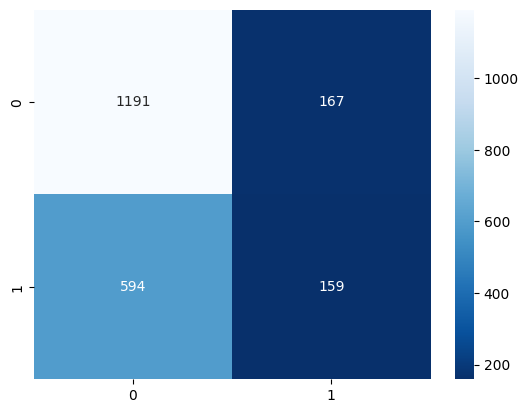

In [ ]:
# построим матрицу ошибок
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r');

Анализ матрицы ошибок:

True Negatives (TN) = 1191 — модель правильно предсказала 0 (низкий риск)

False Positives (FP) = 167 — модель предсказала 1 (высокий риск), хотя по факту 0 (ложная тревога)

False Negatives (FN) = 594 — модель предсказала 0, хотя по факту 1 (высокий риск) — опасная ошибка, человек с риском не определён

True Positives (TP) = 159 — модель правильно предсказала 1 (высокий риск)

Таким образом модель хорошо определяет тех людей, у которых нет риска сердечного приступа, но плохо определяет людей, у котороых он есть

В рамках проекта были построены пайплайны и обучены три модели:

RandomForest, LogisticRegression и CatBoostClassifier

Изначалально каждая из моделей показывала низкую предсказательную способность на кросс-валидации, поэтому был проведён SHAP-анализ признаков, по которому отобраны 10 наиболее влияющих на целевой признак

Далее качество модели было повышено за счёт добавления новых признаков, основанных на доменных знаниях (например, lifestyle_risk, pulse_pressure) и
выбора в качестве метрики взвешенного F1 для учёта дисбаланса классов.

По итогам, взвешенный F1-score на тестовой выборке достиг значения 0.59.

Дополнительно, DummyClassifier подтвердил, что случайное угадывание не даёт значимого результата, а в результате анализа матрицы ошибок стало видно, что модель хорошо определяет тех людей, у которых нет риска сердечного приступа, но плохо определяет людей, у котороых он есть

С учётом высокой стоимости ошибки второго рода (пропуск риска у больного), использование такой модели в продакшене без дополнительной доработки и медицинской верификации может быть потенциально опасным. Рекомендуется дообучение, переоценка признаков и, возможно, изменение подхода (например, фокус на recall для класса 1)

<h2>4. Подготовка предсказания на тестовой выборке</h2>

Составим прдесказания на тестовой выборке и сохраним их в файл. Файл должен быть формата csv и содержать 2 столбца: “id” и “prediction”. CФормируем требуемый файл из имеющихся данных

In [ ]:
test_ids = test_data_copy['id']
X_test_real = test_data_copy.drop(columns=['id'])
y_test_pred = best_model.predict(X_test_real)

submission = pd.DataFrame({
    'id': test_ids,
    'prediction': y_test_pred
})
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/ya/submission.csv', index=False)

<h2> 5. Подготовка скриптов и библиотеки для обработки данных и предсказания на тестовой выборке</h2>

Для обработки данных и прдесказания на тестовой выборке будем использовать FastAPI

Сохраним пайплайн с обучением модели в отдельный файл, чтобы использовать нашу модель в приложении

In [ ]:
joblib.dump(best_model, '/content/drive/MyDrive/Colab Notebooks/ya/model.pkl')

['/content/drive/MyDrive/Colab Notebooks/ya/model.pkl']

Создадим приложение на fastAPI cо следующей структурой<br/>
├── app.py<br/>
├── model.py<br/>
├── test.py
├── model.pkl<br/>
└── templates/<br/>
    ├── start_form.html<br/>
    └── res_form.html<br/>

Основной функционал каждого модуля:

model.py — загрузка заранее сохранённого model.pkl (сквозного пайплайна + лучшей модели) и метод predict, который по входному файлу возвращает список id пациентов с прогнозом риска ≥ порога

app.py — FastAPI-сервер с двумя эндпоинтами: /health для проверки работоспособности и /predict для приёма CSV, вызова HeartRiskModel.predict() и рендеринга HTML с результатами

test.py — простейший скрипт на requests, который проверяет /health и отправляет тестовый submission.csv на /predict

templates — два Jinja2-шаблона: форма загрузки и страница с результатами

Сохраним файл с предсказаниями и мдоель в директорию проекта (приложения)

<h2>6. Написание инструмента для тестирования</2>

Для проведения тестирования запустим наше приложение командой  python -m uvicorn app:app --reload

В браузере перейдём по http://127.0.0.1:8000/health и проверим, что приложение запущено

Затем перейдём на эндпоинт http://127.0.0.1:8000//predict и загрузим наши предсказания, чтобы проверить результаты

Автоматически тоже самое можно сделать посредствам заупска скрипта python test.py

<h2>7. Оформление документации</h2>

Детально опишем работу приложения, также сохраним эту информацию в readme<br/>

Для запуска приложения необходимо скачать папку m1 и всё её содержимое, перейти в папку m1 и выполнить команду python -m uvicorn app:app --reload<br/>

Приложение по предсказанию рисков сердечного приступа использует в качестве сервера FastAPI, в качестве модели — пайплайн, на котором была обучена модель в рамках проекта, с установленым порогом в 0.5
В качестве теста испольщуется простой скрипт, который проверяет, что сервер запущен, и отправляет файл на эндпоинт генерации предсказаний
<br/>
Приложение имееет следующую структуру:<br/>
templates — директория с шаблонами html cтраниц (веб-интерфейс приложения)<br/>
start_form.html страничка, содержащая форму, которая методом post отправляет загруженный файл с данными пациента (аналогичный датасету для теста) на /predict эндпоинт приложения, для обработки файла моделью (прдеварительно обученным пайплайном) и вывода результатов
res_form.html страничка для вывода результатов работы модели, то есть айдишники пациентов, которые, согласно предсказаниям модели, имеют высокий риск сердечного приступа
<br/>
tmp — директория для хранения загруженых файлов<br/>
<br/>
app.py — скрипт, запускающий приложение, используя FastAPI<br/>
сначала мы инициализируем используемые директории (временную и для шаблонов) и модель <br/>
затем через обёртку описываем действие, которе будет происходить при открытии определённой страницы (обработка энд поинта) <br/>
@app.get("/health") при обращении методом get к /health возвращаем 200 ОК<br/>
@app.get("/") при обращении методом get к / (основной странице) отрисовываем форму загрузки файла с реквестом для её отправки на обработку <br/>
@app.post("/predict") при обращении методом к /predict мы получаем реквест и загруженный файл в качестве входных параметров, сохраняем загруженный файл в темп<br/>
делаем предсказания обученой моделью через model.predict<br/>
в случае ошибки добавляем к url параметр /?error и текст ошибки, кидаем статус 303<br/>
отрисовываем результат предсказаний модели на странничке res_form<br/>
<br/>
model.py - скрипт для работы модели и предобработки загруженного файла, аналогично тому что делалось в проекте<br/>
сначала мы объявляем 10 фич, по которым работает модель в TOP_FEATURES<br/>
в HeartRiskModel содержатся несколько методов, в которых описана логика работы с моделью<br/>
в методе init мы загружаем предварительно обученную модель из файла model.pkl и ставим ей threshold в 0.5<br/>
в методе feature_engineering создаём новые признаки<br/>
в методе predict читаем ранее загруженный файл через pandas, переименовываем названия столбцов, приводя их к нормальному виду<br/>
добавляем новые признаки через feature_engineering<br/>
сохраняем списк айдишников<br/>
в Х берём только топ-10 признаков<br/>
запускаем предсказания модели для Х predict_proba, возвращаем айди тех пациентов, у которых риск есть<br/>
<br/>
test.py — используется для теста (что сервер поднят)<br/>
если get к /health равен 200 ОК,  200 ОК<br/>
кидаем submission.csv в /predict (но этот файл не подходит по формату)<br/>